## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [2]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations
from tinnsleep.data import read_etiology_file

print("config loaded")


config loaded


In [3]:
#Setting parameters
results_file = "data/reports_and_datas_bruxism.pk"
info_file = "data/data_info.csv"
etiology_file = "data/etiology.xlsx"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change to --overwrite True if you want to force to recompute the results
%run ../compute_results.py --bruxism True --mema False --overwrite True


config loaded.
Performs Bruxism: <True>
Performs MEMA: <False>
Will overwrite existing results: <True>
parameters set
Files processed: 
1PI07_nuit_hab.edf Chan machoire
[0, 4]
['1', '1 Imp?dance', '1-2', '1-F', '2', '2 Imp?dance', '2-F', 'Abdomen', 'Activity', 'X Axis', 'Y Axis', 'Z Axis', 'C3', 'C3 Imp?dance', 'C3-M2', 'C4', 'C4 Imp?dance', 'C4-M1', 'E1', 'E1 Imp?dance', 'E1-M2', 'E1-M2 (Imp)', 'E2', 'E2 Imp?dance', 'E2-M1', 'E2-M1 (Imp)', 'ECG Imp?dance', 'F', 'F Imp?dance', 'F3', 'F3 Imp?dance', 'F3-M2', 'F4', 'F4 Imp?dance', 'F4-M1', 'Heart Rate', 'Jambe droite Im', 'Jambe gauche Im', 'M1', 'M1 Imp?dance', 'M1M2', 'M2', 'M2 Imp?dance', 'O1', 'O1 Imp?dance', 'O1-M2', 'O2', 'O2 Imp?dance', 'O2-M1', 'PosAngle', 'Chest', 'Volume audio', 'Audio Volume dB']
(sleep labels not found) preprocess... Bruxism({'suppressed_is_good': 30, 'suppressed_amp_thr': 0, 'suppressed_overall': 30, 'total_nb_epochs': 113880, 'suppressed_ratio': 0.00026343519494204424}
done) MEMA(skipped) {'suppressed_is_go

# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('emg == 1 & included == 1 & session == "1" & to_suppress==0')
etiology = read_etiology_file(etiology_file)
data_info = data_info.merge(etiology,on="subject")

print(f"Valid files for bruxism {data_info.shape[0]}")
print(data_info[["filename", "condition", "hyperacusis"]])

# keep only results from query
results= {filename:results[filename] for filename in data_info["filename"].values}

Valid files for bruxism 31
              filename    condition  hyperacusis
0   1BA07_nuit_hab.edf  habituation        False
1   1CC05_nuit_hab.edf  habituation         True
2   1DA15_nuit_hab.edf  habituation         True
3   1DL12_nuit_hab.edf  habituation        False
4   1GB18_nuit_hab.edf  habituation        False
5   1MF19_nuit_hab.edf  habituation        False
6   1MN09_nuit_hab.edf  habituation         True
7   1PI07_nuit_hab.edf  habituation         True
8   1PT06_nuit_hab.edf  habituation         True
9   1SA14_nuit_hab.edf  habituation         True
10  1ZN04_nuit_hab.edf  habituation         True
11   1ZN04_cohort2.edf       batch2         True
12    1HB20_nuit_1.edf  habituation        False
13    1SL21_nuit_2.edf  habituation        False
14    1UC22_nuit_1.edf  habituation        False
15    2SJ03_nuit_1.edf      control        False
16    2LS05_nuit_1.edf      control        False
17    2CT04_nuit_1.edf      control        False
18   1HS25_cohort2.edf       batch2       

## 2.a Number of episode per hour

In [5]:
# vizualization function
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        y_axis=[]
        for report in results[filename]["reports"]:
            y_axis.append(report[value])
        plt.plot(THR_classif[:,1], y_axis, label=filename)
    plt.title('Bruxism scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

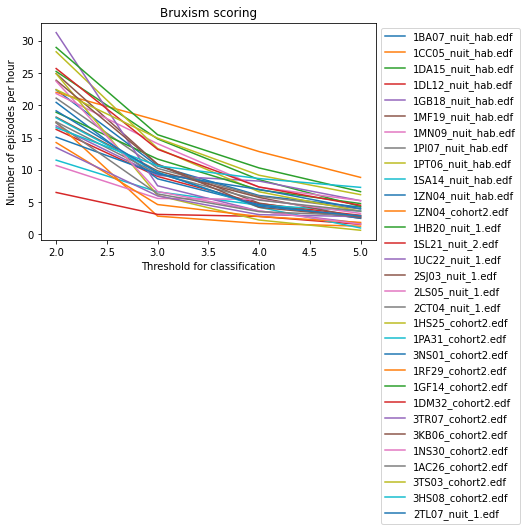

In [6]:
plt.close("all")
plt.figure()
value = "Number of episodes per hour"
plot_inter_subjects(results, value)

## 2.b Burst Duration 

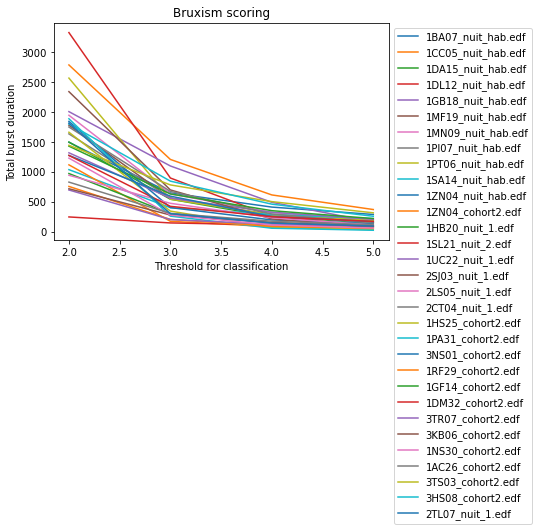

In [7]:
plt.figure()
value = "Total burst duration"
plot_inter_subjects(results, value)

## 2.c Logs of the preprocessing

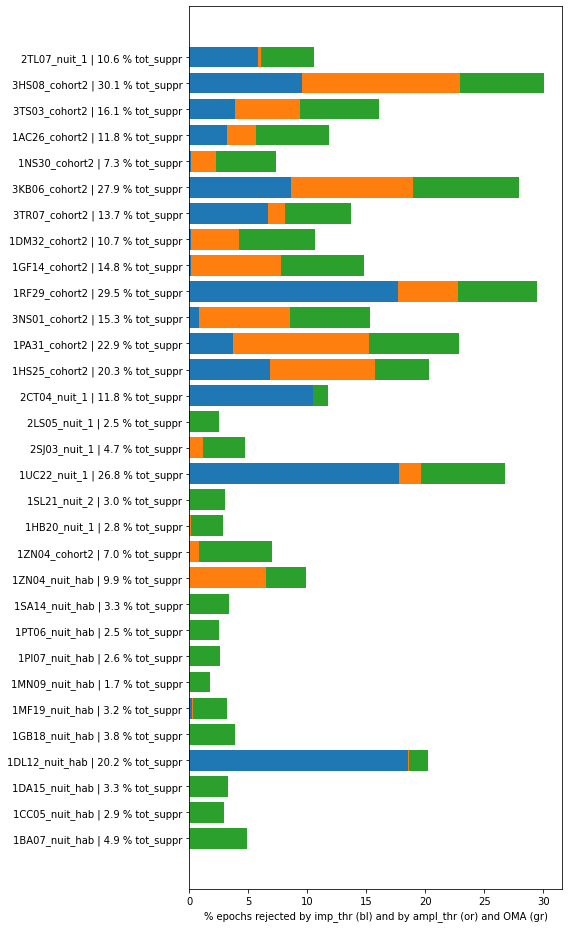

In [8]:
file=[]
suppr_imp=[]
suppr_amp=[]
suppr_OMA=[]
for elm in results.keys():
    #print(results[elm]["log"])
    #if results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'] > 0.0001:
        sum_suppr= results[elm]["log"]["IMP"]['suppressed_overall']/results[elm]["log"]["IMP"]['total_nb_epochs'] + results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'] + results[elm]["log"]["OMA"]['suppressed_overall']/results[elm]["log"]["OMA"]['total_nb_epochs']
        file.append(elm.split(os.path.sep)[-1][:-4] + " | " + 
                    str("%.1f" % (100.0 *sum_suppr))
                   + " % tot_suppr")
        suppr_imp.append(100*(results[elm]["log"]["IMP"]['suppressed_overall']/results[elm]["log"]["IMP"]['total_nb_epochs']))
        suppr_amp.append(100*results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'])
        suppr_OMA.append(100*results[elm]["log"]["OMA"]['suppressed_overall']/results[elm]["log"]["OMA"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
starts=[]
for i in range(len(suppr_imp)):
    starts.append(suppr_imp[i]+ suppr_amp[i])
rect3 = ax.barh(file, suppr_OMA, left=starts)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or) and OMA (gr)")
plt.tight_layout()
plt.show()


## 2.d Comparing episode frequency with variability tinnitus

Nb_patients in each group : 
Tinnitus increase : 15, ['1BA07', '1CC05', '1GB18', '1MF19', '1MN09', '1PI07', '1SA14', '1ZN04', '1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26', '3TS03']
Tinnitus decrease : 9, ['1DA15', '1DL12', '1ZN04', '1HB20', '1SL21', '3NS01', '3TR07', '3KB06', '3HS08']
Tinnitus stable : 3, ['1PT06', '1PA31', '1RF29']
Tinnitus control : 4, ['2SJ03', '2LS05', '2CT04', '2TL07']
Tests pour un THR de 2
Ttest_indResult(statistic=-2.2717009262374477, pvalue=0.03638145654105269)
Ttest_indResult(statistic=-2.4706619321340124, pvalue=0.021711734985153525)
Ttest_indResult(statistic=-0.6546847661092824, pvalue=0.5219717094934474)
Tests pour un THR de 3
Ttest_indResult(statistic=-0.9712271914477156, pvalue=0.34505219574015356)
Ttest_indResult(statistic=-1.131439698728138, pvalue=0.27005313327344316)
Ttest_indResult(statistic=-0.5450196790964239, pvalue=0.5932565482983576)
Tests pour un THR de 4
Ttest_indResult(statistic=-0.7144736445936725, pvalue=0.4846304298731533)
Ttest_i

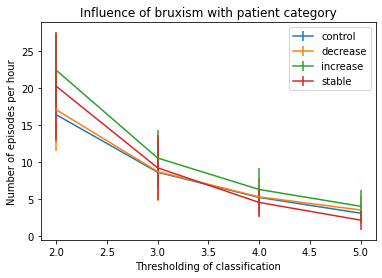

In [9]:
# d.1 GROUP BY TINNITUS VOLUME VARIATION
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["mask_delta"].apply(map_category)

reports = reports.merge(data_info, on="filename")

# d.2 reparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

# d.3 Displaying
plt.figure()
value = "Number of episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Influence of bruxism with patient category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()
          
l=[]
for i in range(16):
    l.append(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of episodes per hour"]))
print("Tests pour un THR de 2")
print(scipy.stats.ttest_ind(l[0], l[8]))
print(scipy.stats.ttest_ind(l[4], l[8]))
print(scipy.stats.ttest_ind(l[12], l[8]))
print("Tests pour un THR de 3")
print(scipy.stats.ttest_ind(l[1], l[9]))
print(scipy.stats.ttest_ind(l[5], l[9]))
print(scipy.stats.ttest_ind(l[13], l[9]))
print("Tests pour un THR de 4")
print(scipy.stats.ttest_ind(l[2], l[10]))
print(scipy.stats.ttest_ind(l[6], l[10]))
print(scipy.stats.ttest_ind(l[14], l[10]))
print("Tests pour un THR de 5")
print(scipy.stats.ttest_ind(l[3], l[11]))
print(scipy.stats.ttest_ind(l[7], l[11]))
print(scipy.stats.ttest_ind(l[15], l[11]))

## 2.e Etiology

etiology (?) : 60, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22']
etiology (group1) : 28, ['1HS25', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '1AC26']
etiology (group3) : 20, ['3NS01', '3NS01', '3NS01', '3NS01', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3T

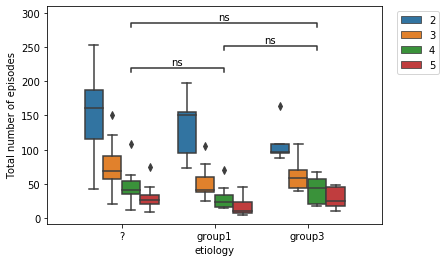

obstructed_ear (False) : 64, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1HB20', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08', '3HS08']
obstructed_ear (True) : 44, ['1GB18', '1GB18', '1GB18', '1GB18', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1NS30', '1AC2

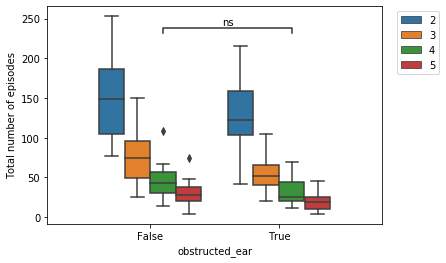

otalgy (False) : 84, ['1BA07', '1BA07', '1BA07', '1BA07', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3TS03']
otalgy (True) : 24, ['1CC05', '1CC05', '1CC05', '1CC05', '1PT06', '1PT06', '1PT06', '1PT06', '1PA31', '1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '1DM32', '1AC26', '1AC26', '1AC26', '1AC26', '3HS08', '3HS08', '3H

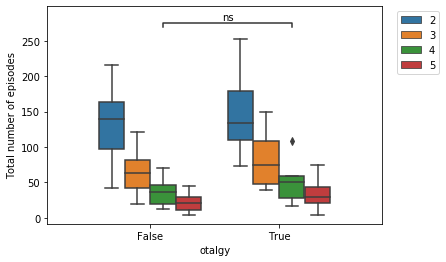

hyperacusis (False) : 48, ['1BA07', '1BA07', '1BA07', '1BA07', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3NS01', '3TR07', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '1AC26']
hyperacusis (True) : 60, ['1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', '3

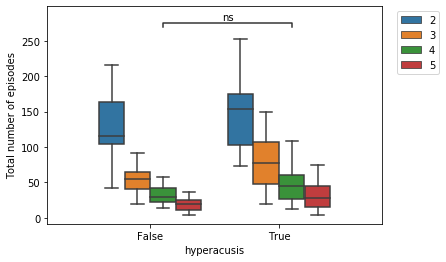

jaw_popping (False) : 56, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1HB20', '1HB20', '1HB20', '1HB20', '1UC22', '1UC22', '1UC22', '1UC22', '1RF29', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3TS03']
jaw_popping (True) : 52, ['1DA15', '1DA15', '1DA15', '1DA15', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1SL21', '1SL21', '1SL21', '1SL21', '1HS25', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1NS30', '3HS08', '3

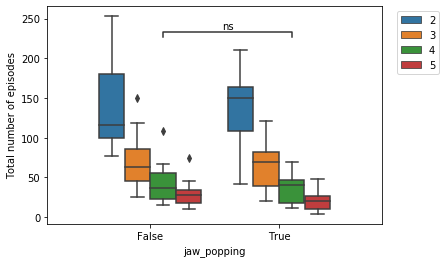

jaw_pain_and_fatigue (False) : 92, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '3NS01', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08', '3HS08']
jaw_pain_and_fatigue (True) : 16, ['1HS25', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '1

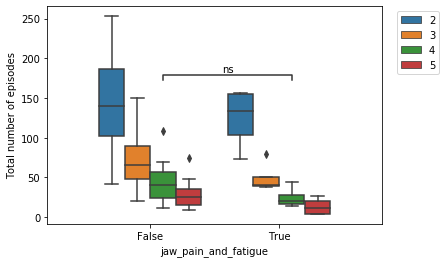

somatosensory_modulation (False) : 80, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '3NS01', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1RF29', '1DM32', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08', '3HS08']
somatosensory_modulation (True) : 28, ['1PI07', '1PI07', '1PI07', '1PI07', '1UC22', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1PA31', '1GF14', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3T

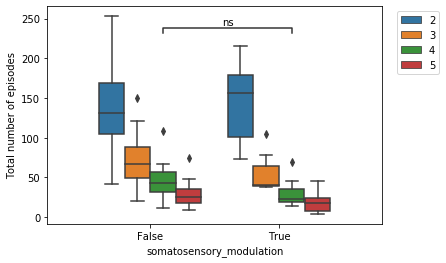

nap_modulation (True) : 32, ['1BA07', '1BA07', '1BA07', '1BA07', '1DL12', '1DL12', '1DL12', '1DL12', '1PI07', '1PI07', '1PI07', '1PI07', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29', '1RF29']
nap_modulation (False) : 76, ['1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3TS03', '3HS0

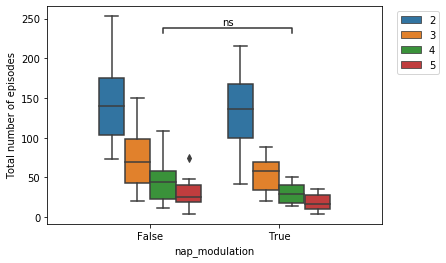

snoring (False) : 68, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MN09', '1MN09', '1MN09', '1MN09', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '3TR07', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08', '3HS08']
snoring (True) : 40, ['1MF19', '1MF19', '1MF19', '1MF19', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1RF29', '3KB06', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '

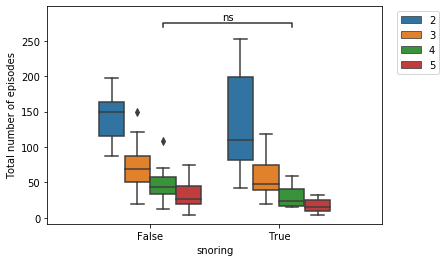

neck_pain (True) : 68, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1HB20', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3TS03']
neck_pain (False) : 40, ['1GB18', '1GB18', '1GB18', '1GB18', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '3TR07', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08

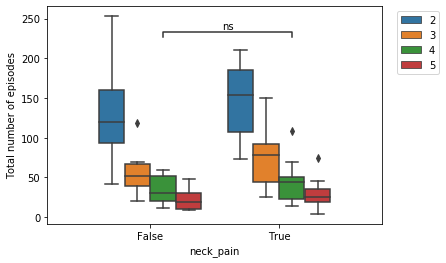

trauma_sonore (False) : 72, ['1BA07', '1BA07', '1BA07', '1BA07', '1DL12', '1DL12', '1DL12', '1DL12', '1MF19', '1MF19', '1MF19', '1MF19', '1PI07', '1PI07', '1PI07', '1PI07', '1SA14', '1SA14', '1SA14', '1SA14', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1HS25', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3TS03']
trauma_sonore (True) : 36, ['1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1GB18', '1GB18', '1GB18', '1GB18', '1MN09', '1MN09', '1MN09', '1MN09', '1PT06', '1PT06', '1PT06', '1PT06', '1UC22', '1UC22', '1UC22', '1UC22', '3TR07', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1NS30', '3HS08'

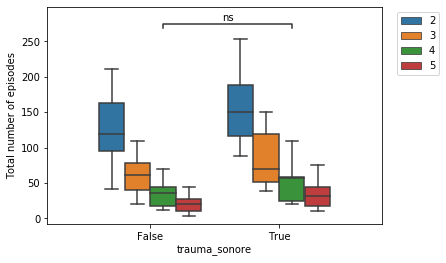

otite (False) : 60, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1MN09', '1MN09', '1MN09', '1MN09', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1HS25', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3NS01', '1DM32', '1DM32', '1DM32', '1DM32', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08', '3HS08']
otite (True) : 48, ['1DL12', '1DL12', '1DL12', '1DL12', '1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '1AC26', '1AC26', '1AC2

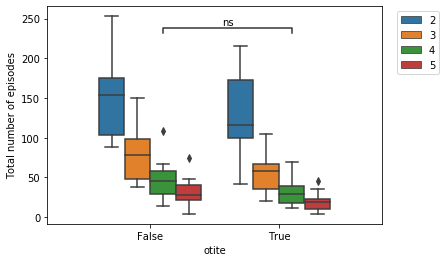

Ear clapping (False) : 52, ['1BA07', '1BA07', '1BA07', '1BA07', '1CC05', '1CC05', '1CC05', '1CC05', '1DA15', '1DA15', '1DA15', '1DA15', '1DL12', '1DL12', '1DL12', '1DL12', '1PI07', '1PI07', '1PI07', '1PI07', '1PT06', '1PT06', '1PT06', '1PT06', '1SA14', '1SA14', '1SA14', '1SA14', '1HB20', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1SL21', '1HS25', '1HS25', '1HS25', '1HS25', '1DM32', '1DM32', '1DM32', '1DM32', '3TR07', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3KB06']
Ear clapping (True) : 56, ['1GB18', '1GB18', '1GB18', '1GB18', '1MF19', '1MF19', '1MF19', '1MF19', '1MN09', '1MN09', '1MN09', '1MN09', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1ZN04', '1UC22', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1GF14', '1NS30', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3TS03', '3HS08', 

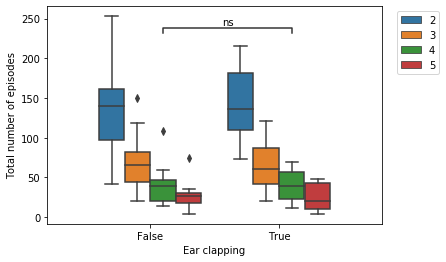

In [19]:
# ETIOLOGIES
from tinnsleep.visualization import etiology_report_with_plot
plt.close("all")
data = reports.query("category != 'control'")
variable = 'Number of episodes per hour'
variable = 'Total number of episodes'
hue = "THR_classif"
threshold = 4

etiologies = ['etiology', 'obstructed_ear', 'otalgy', 'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 
            'somatosensory_modulation', 'nap_modulation', 'snoring', "neck_pain", "trauma_sonore", "otite",
             "Ear clapping"]
for etiology in etiologies:
    etiology_report_with_plot(data, etiology, variable, hue=hue, hue_value_for_stats=threshold)
    plt.show()

## 2.f Screen for correlated variables

In [13]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())[0:-1] #(remove power ratio)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]

variables: ['Clean data duration', 'Total burst duration', 'Total number of burst', 'Number of bursts per hour', 'Total number of episodes', 'Number of bursts per episode', 'Number of episodes per hour', 'Number of tonic episodes per hour', 'Number of phasic episodes per hour', 'Number of mixed episodes per hour', 'Mean duration of tonic episode', 'Mean duration of phasic episode', 'Mean duration of mixed episode']


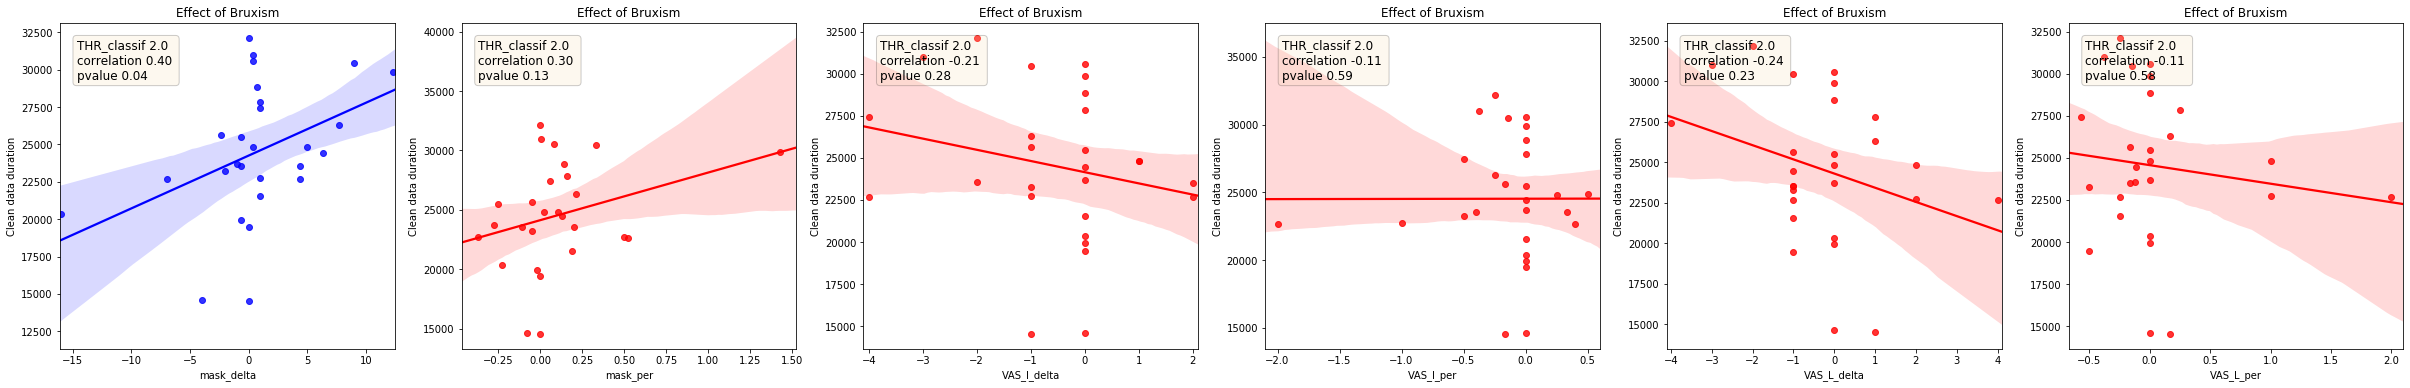

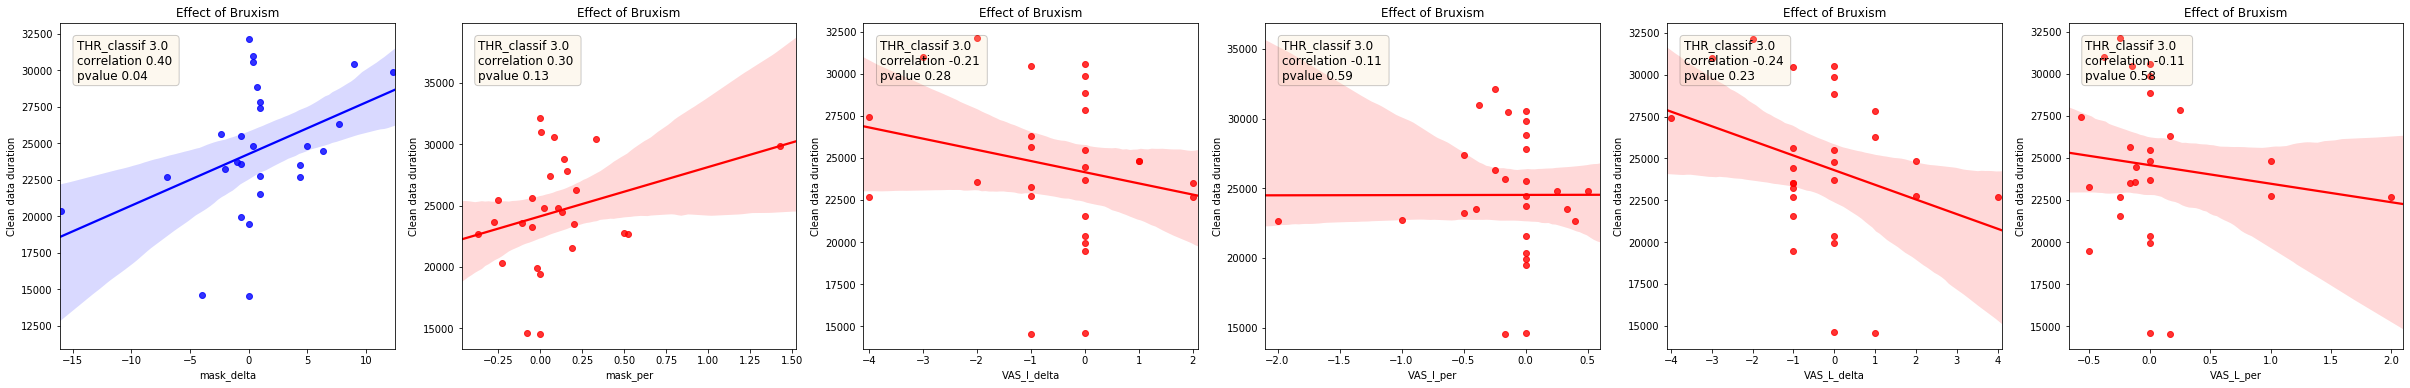

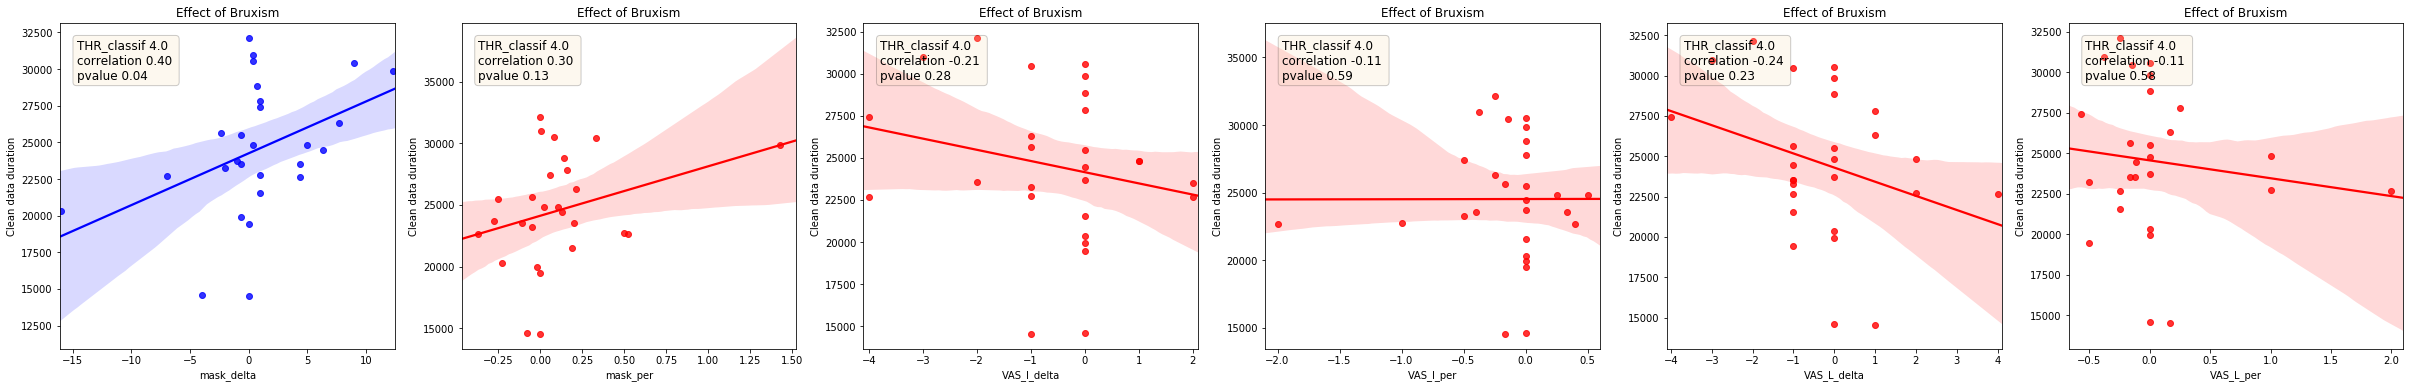

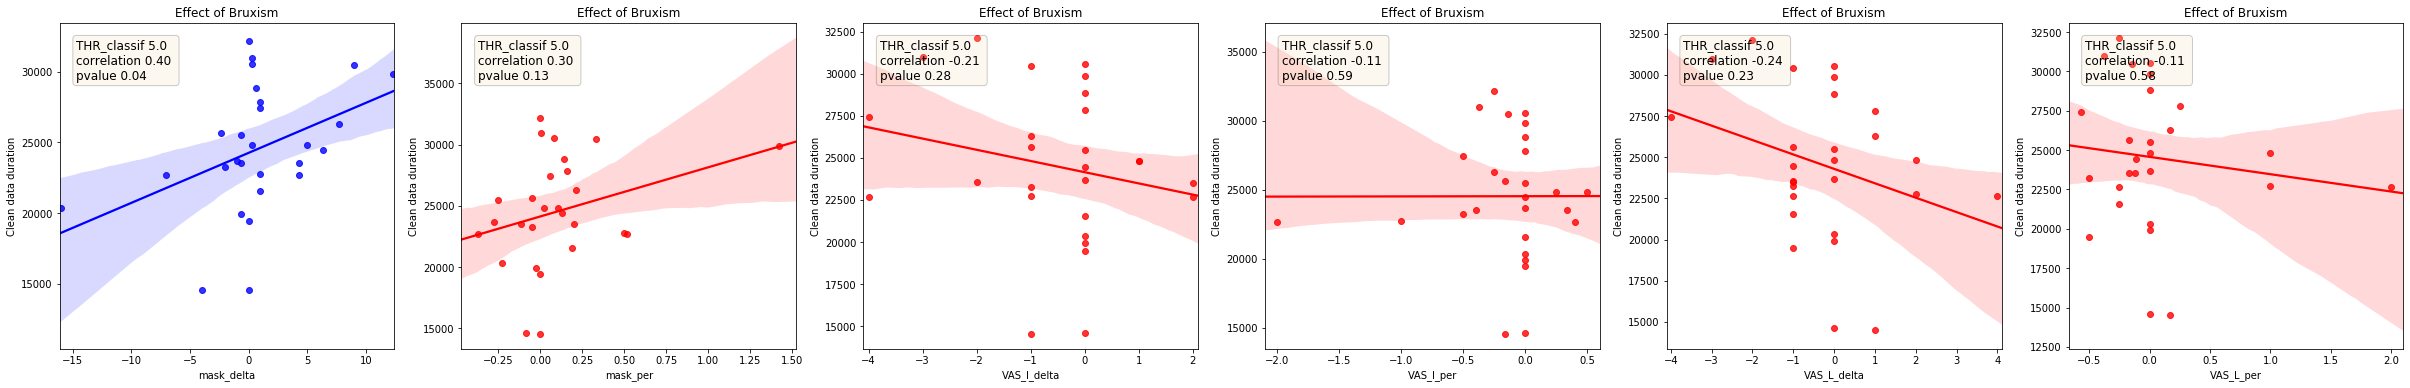

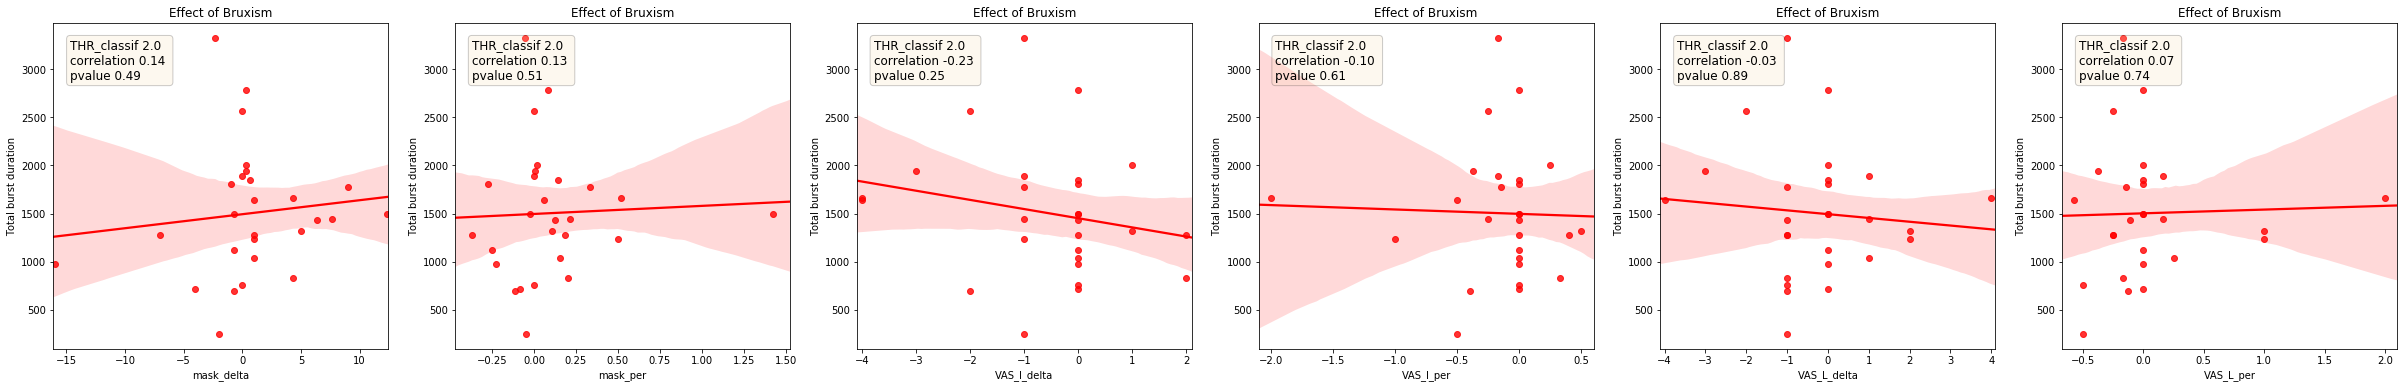

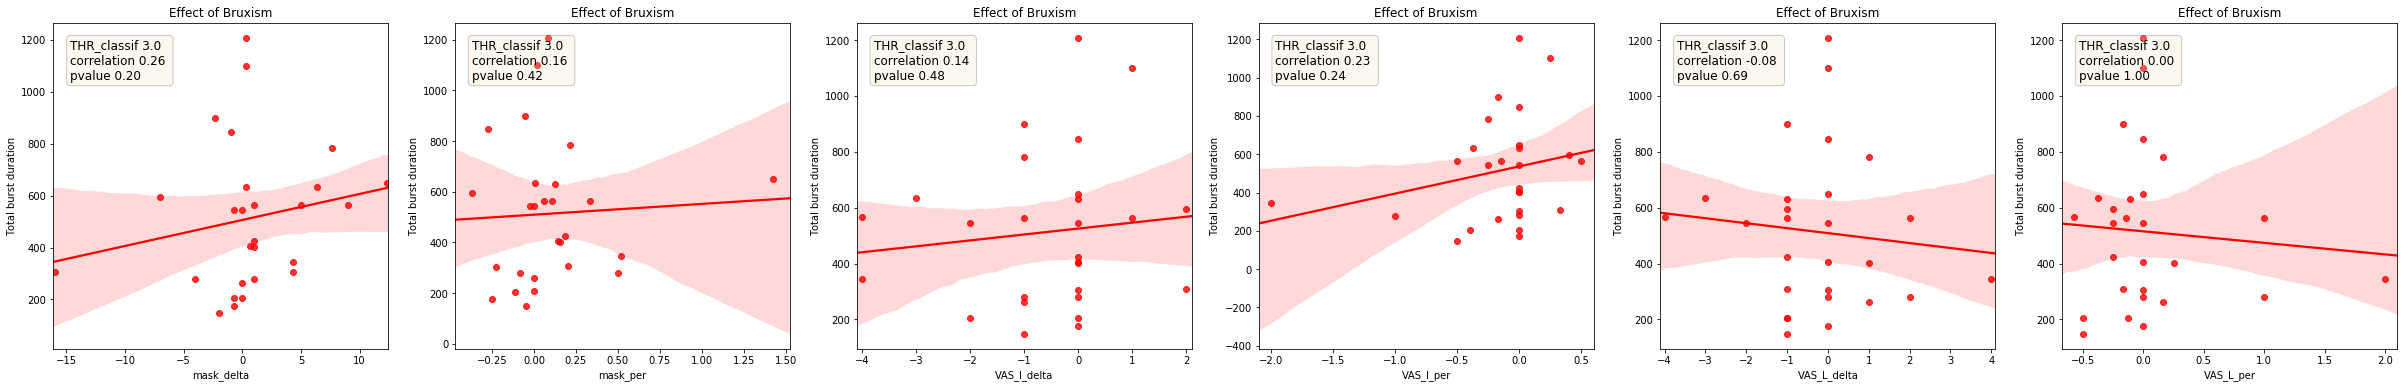

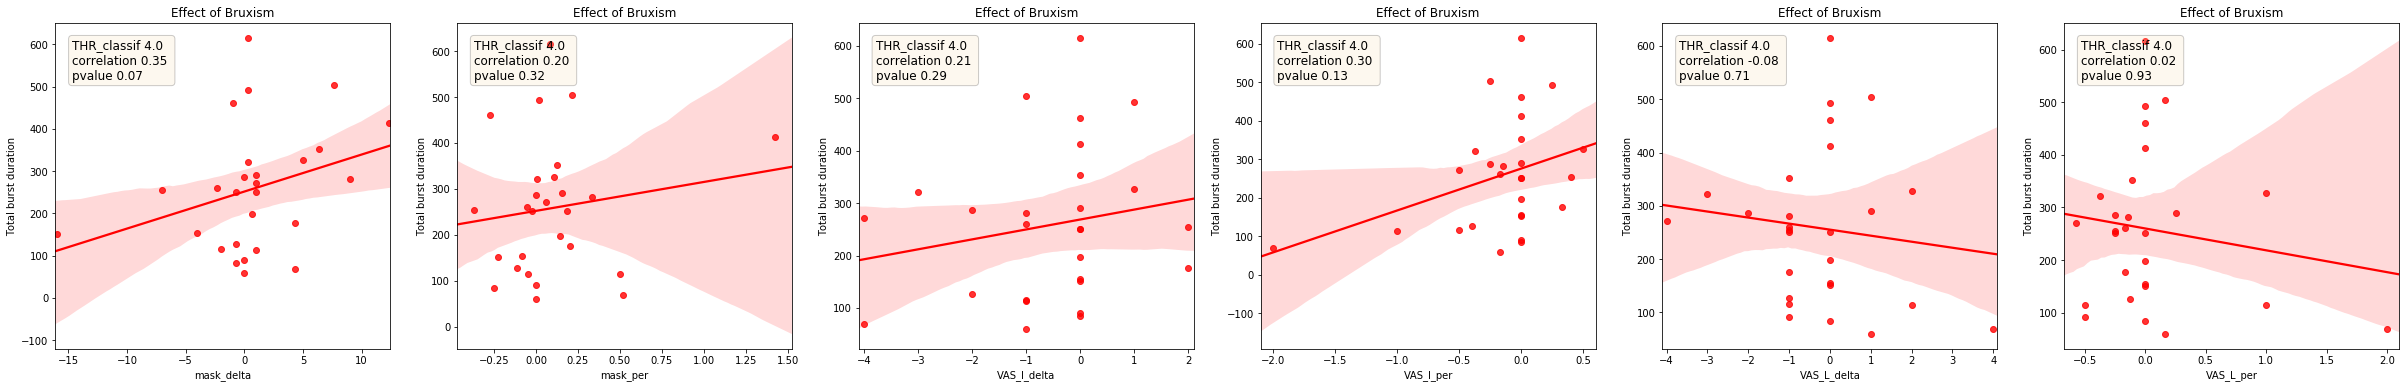

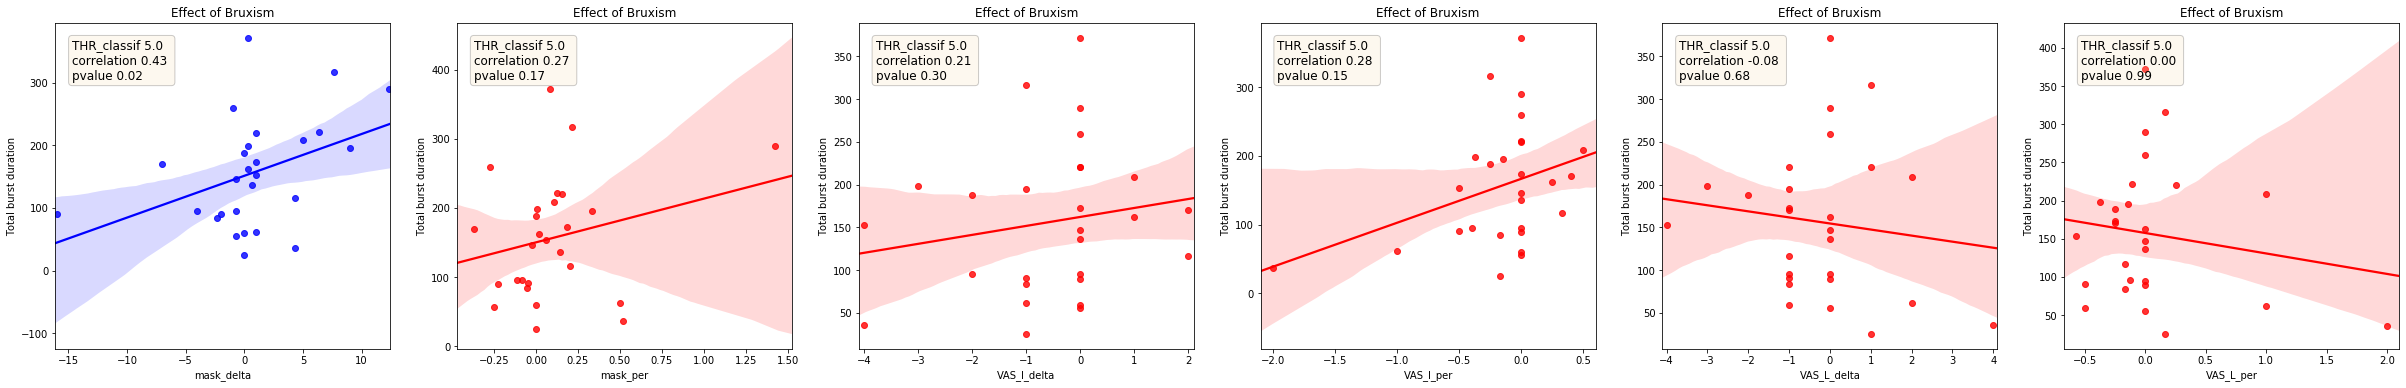

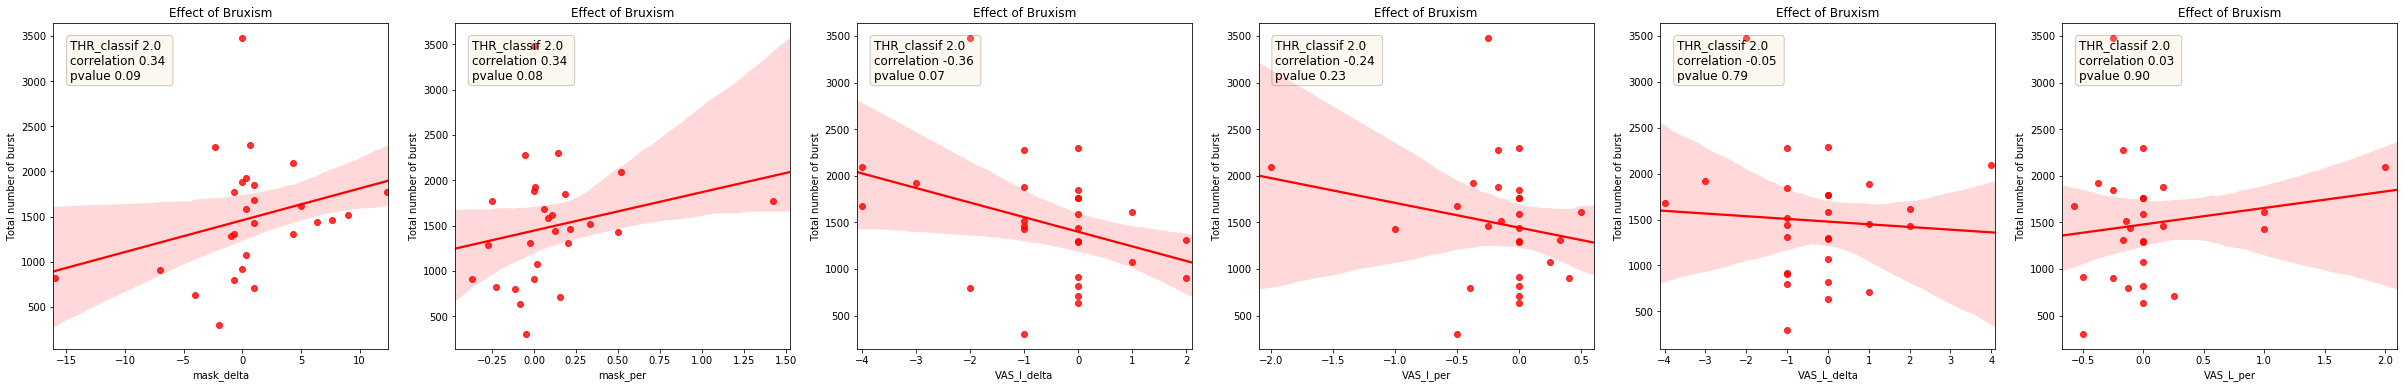

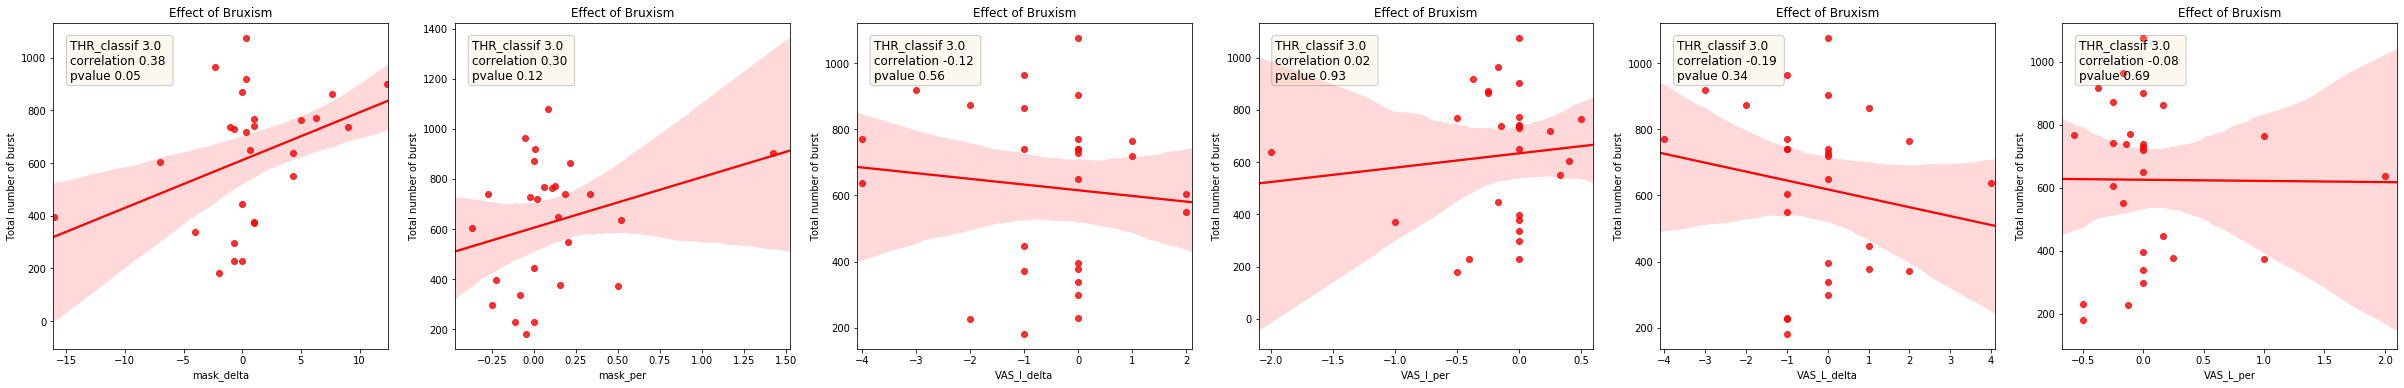

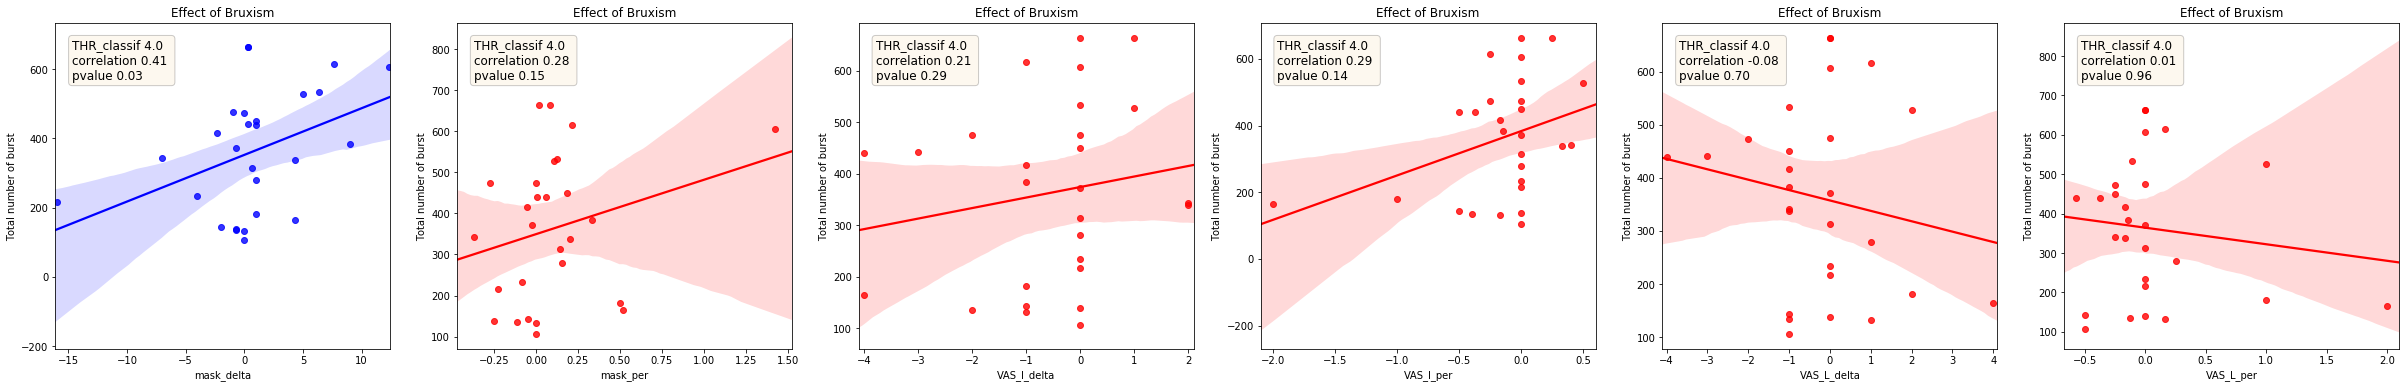

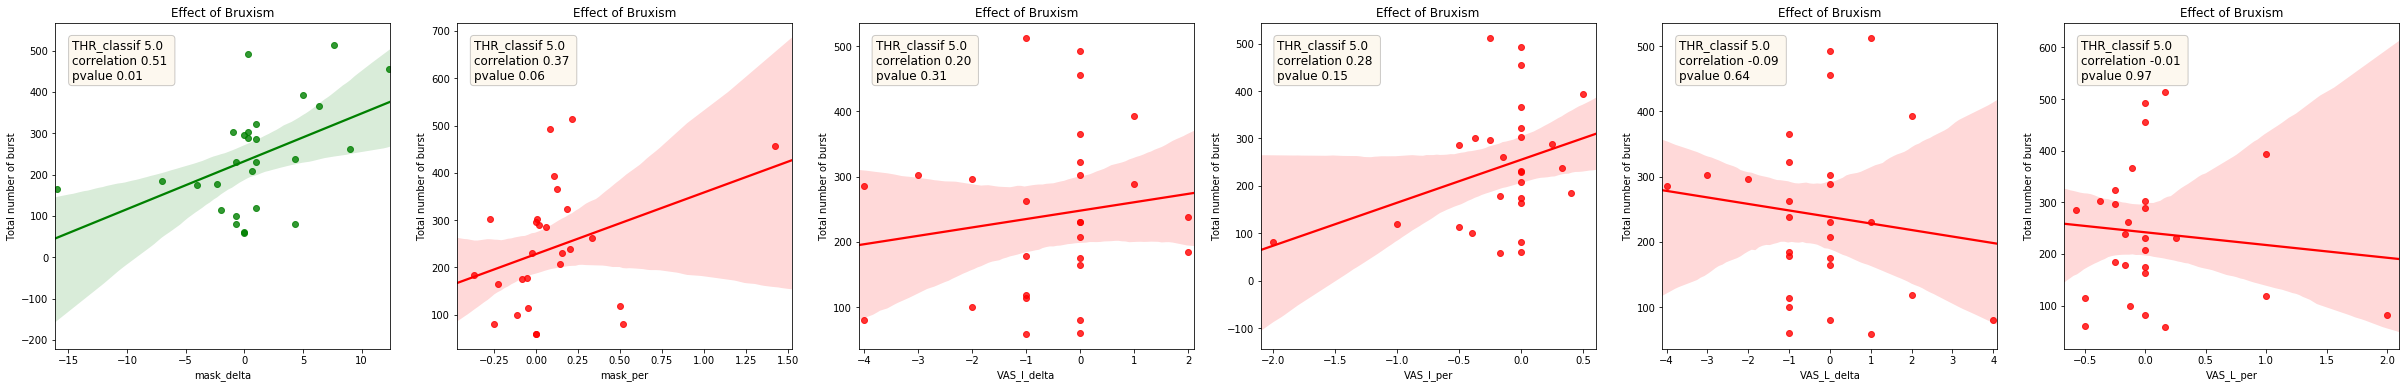

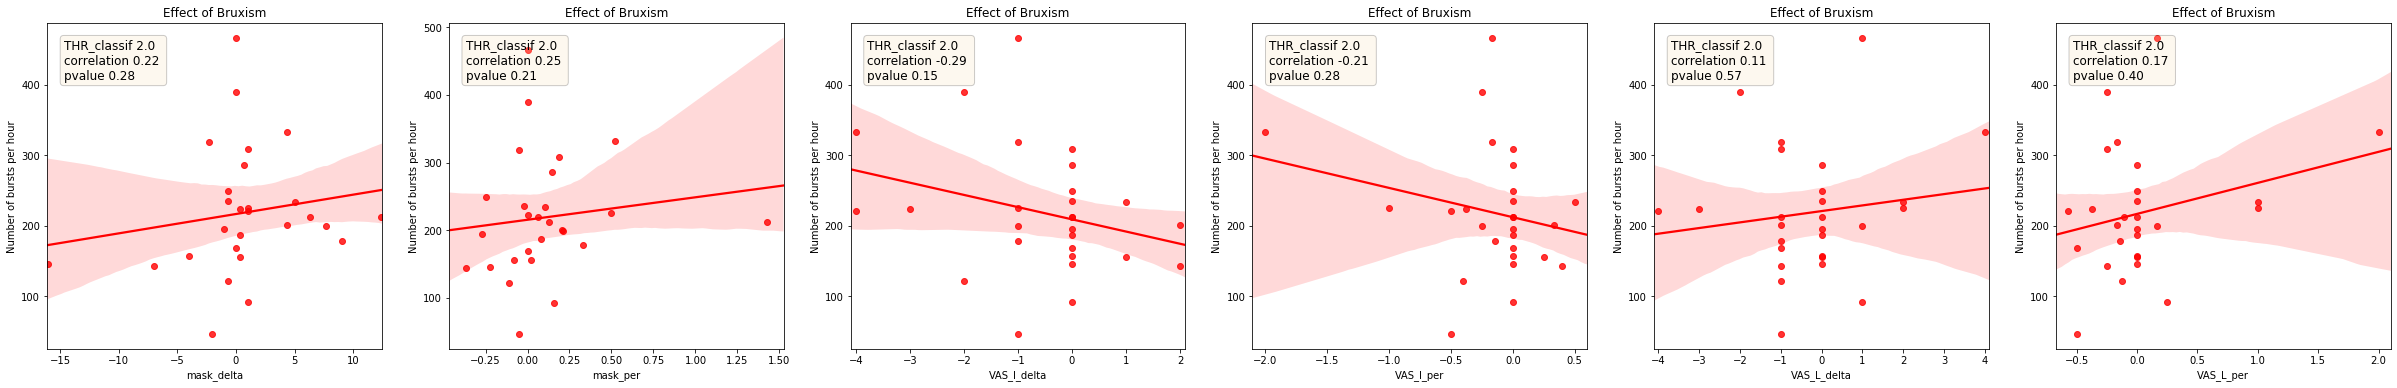

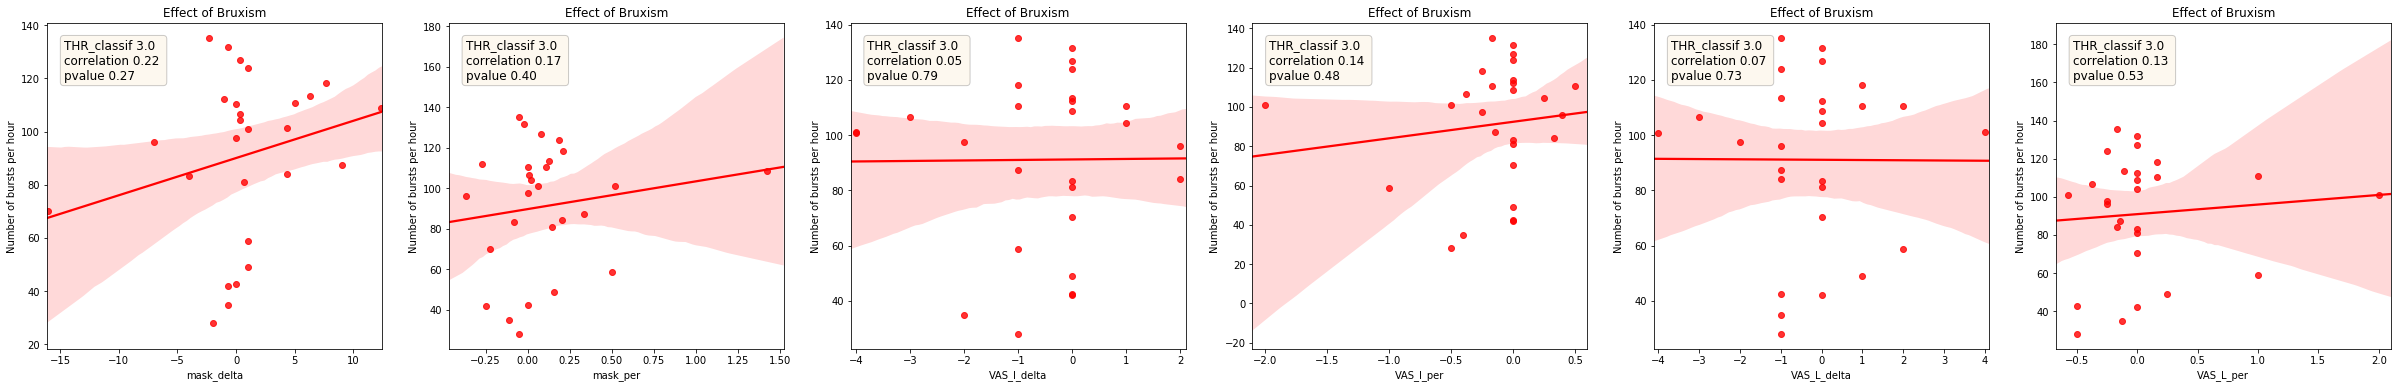

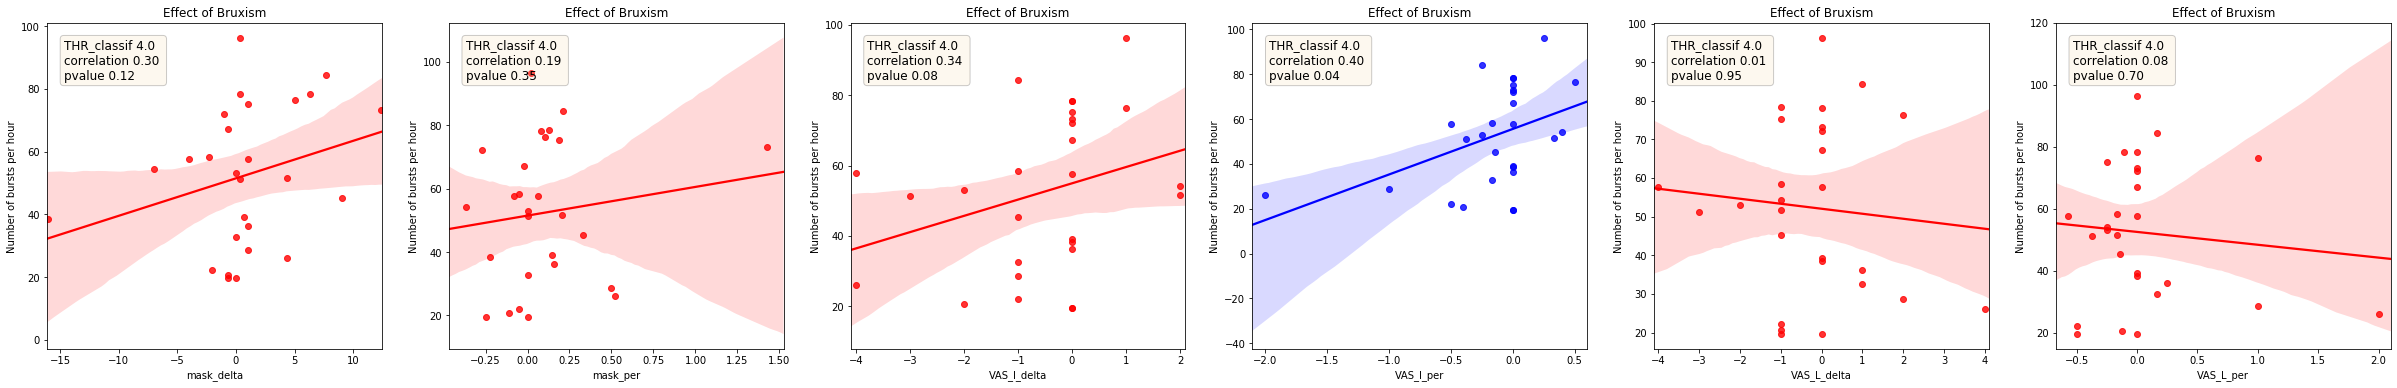

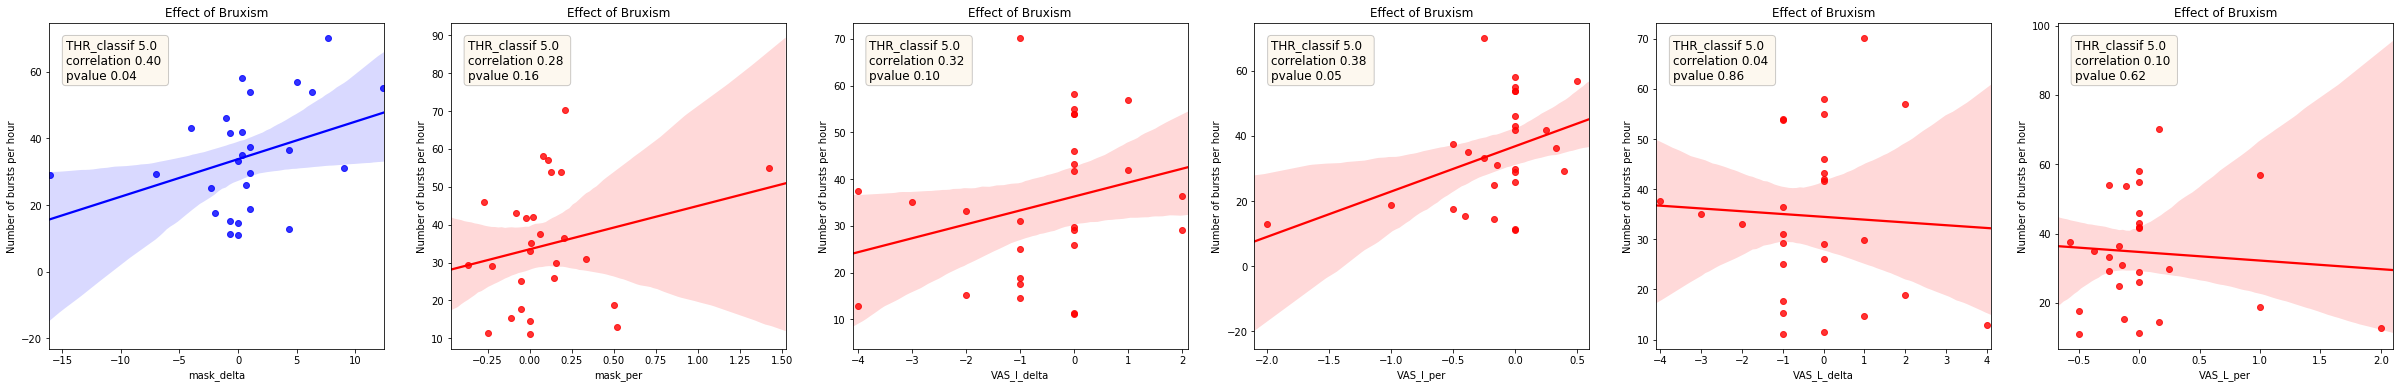

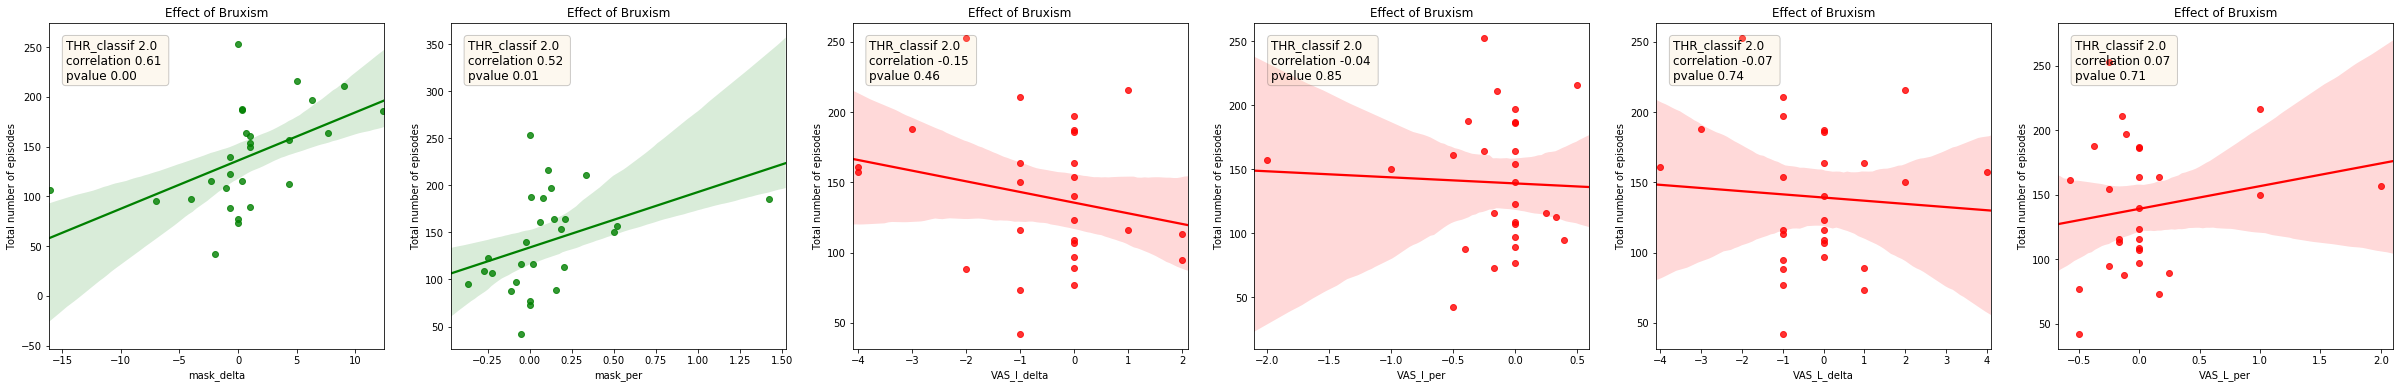

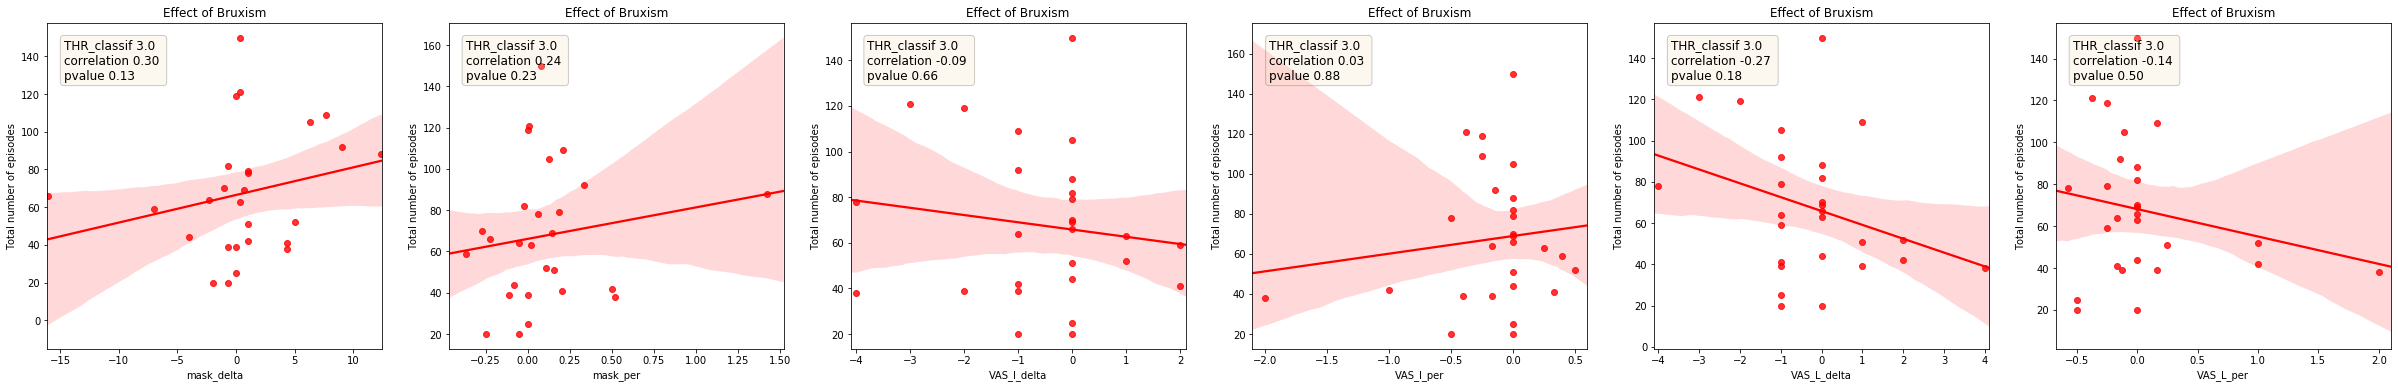

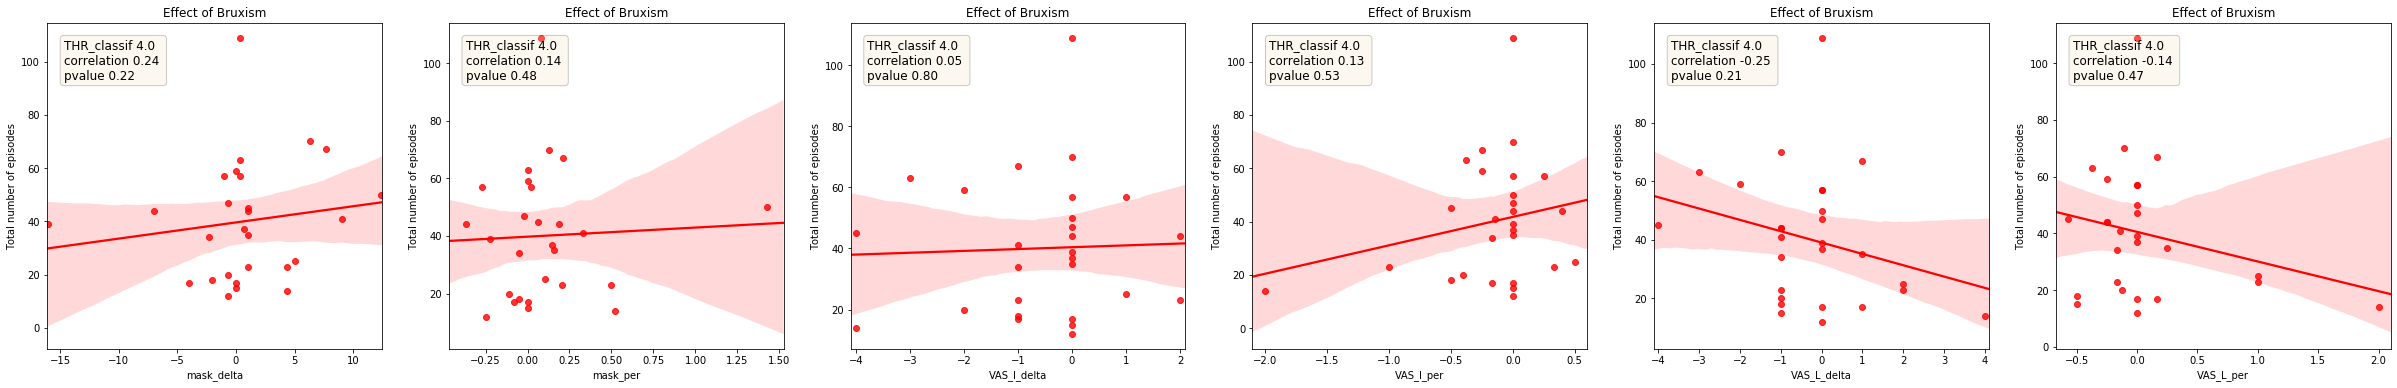

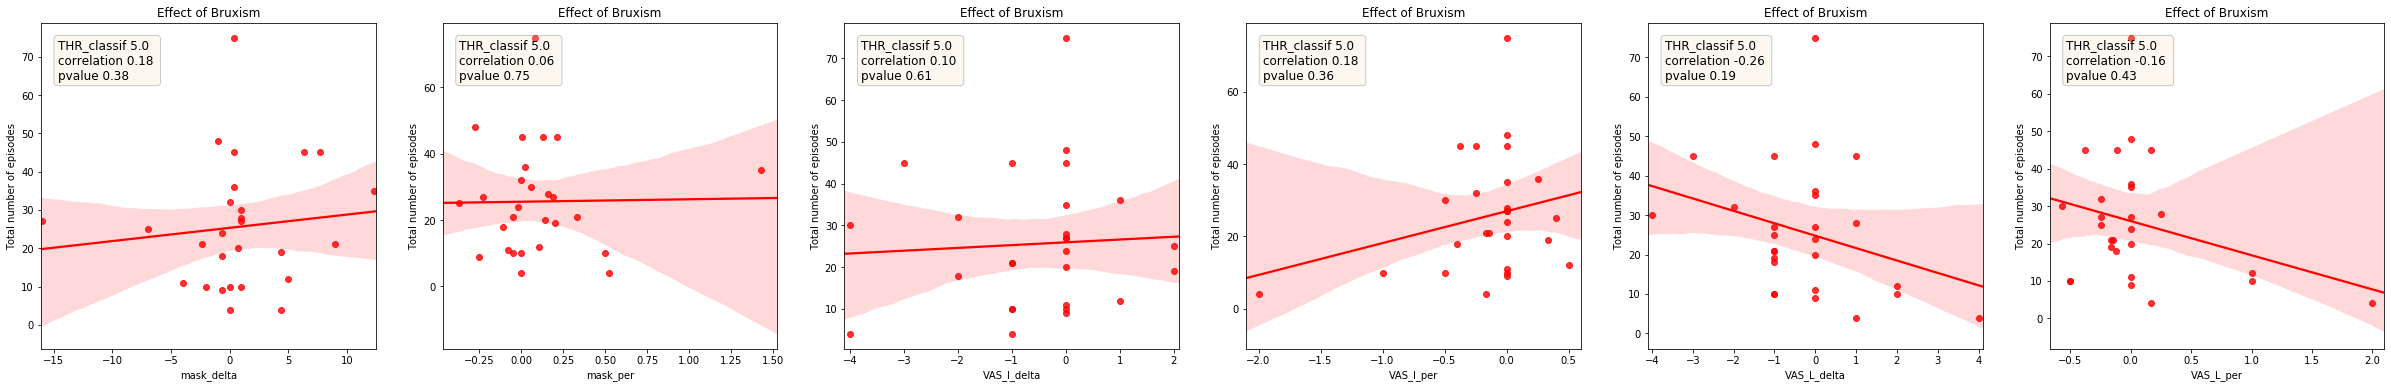

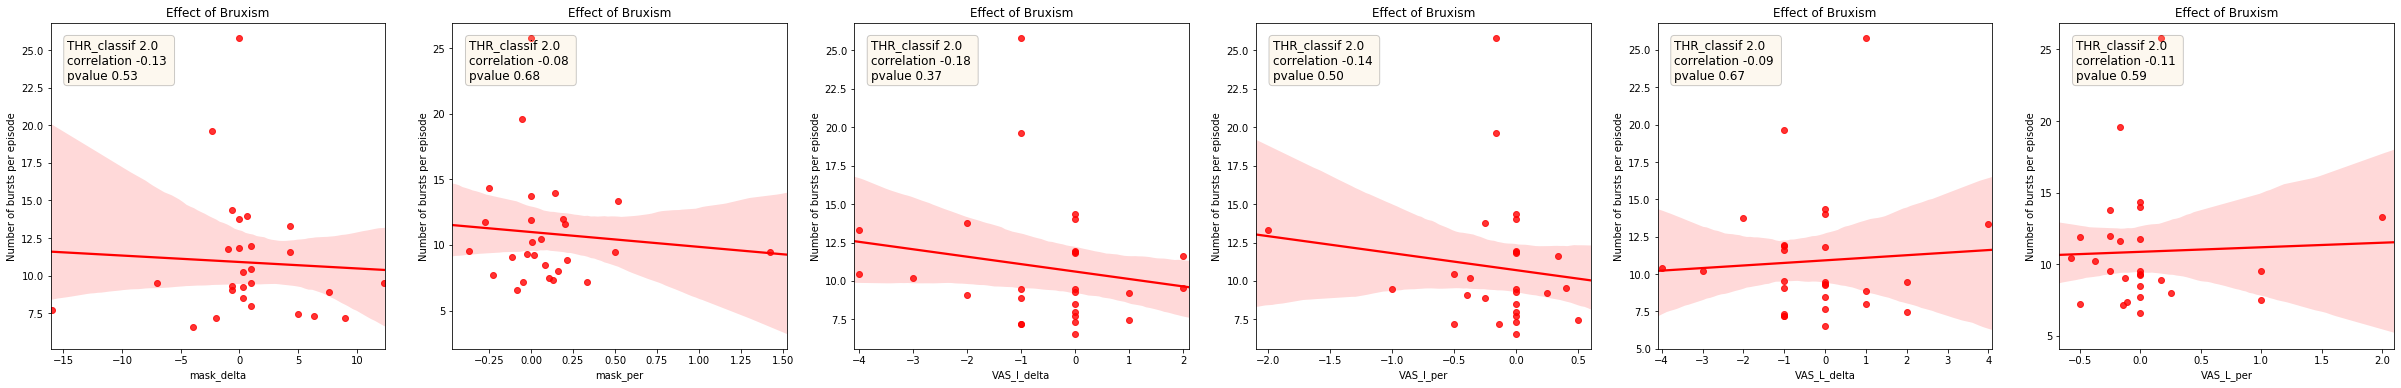

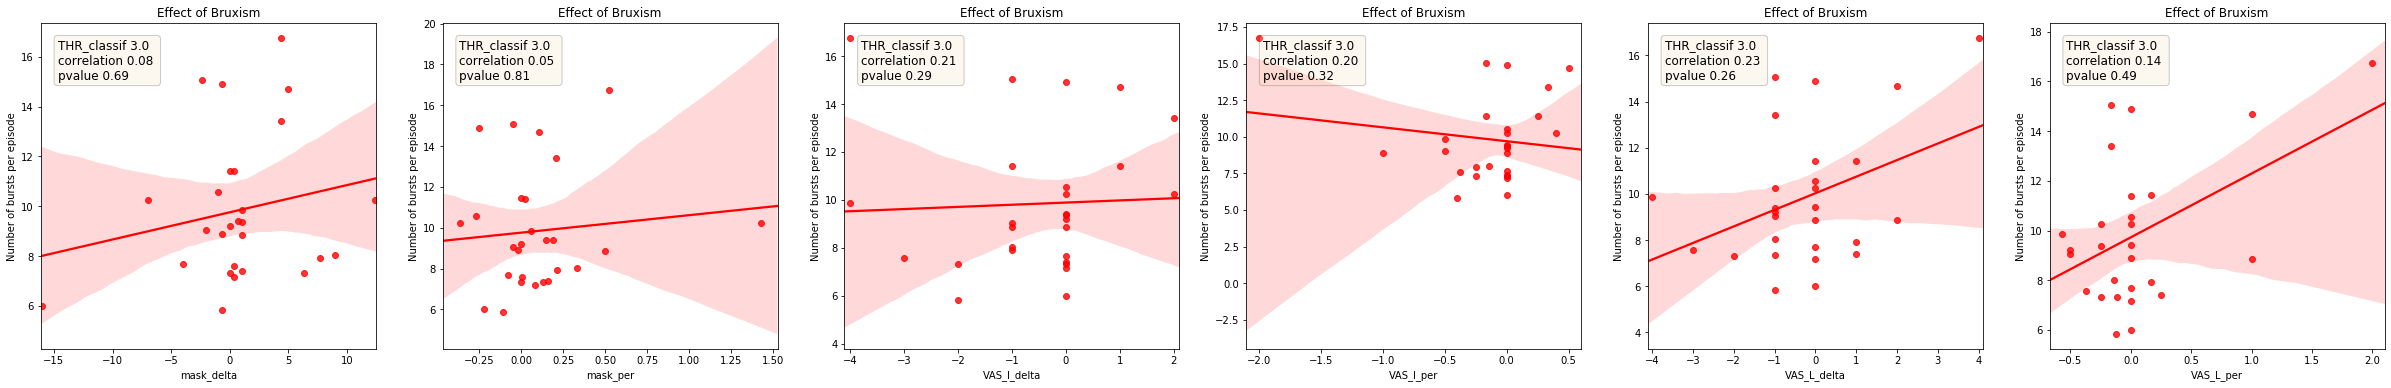

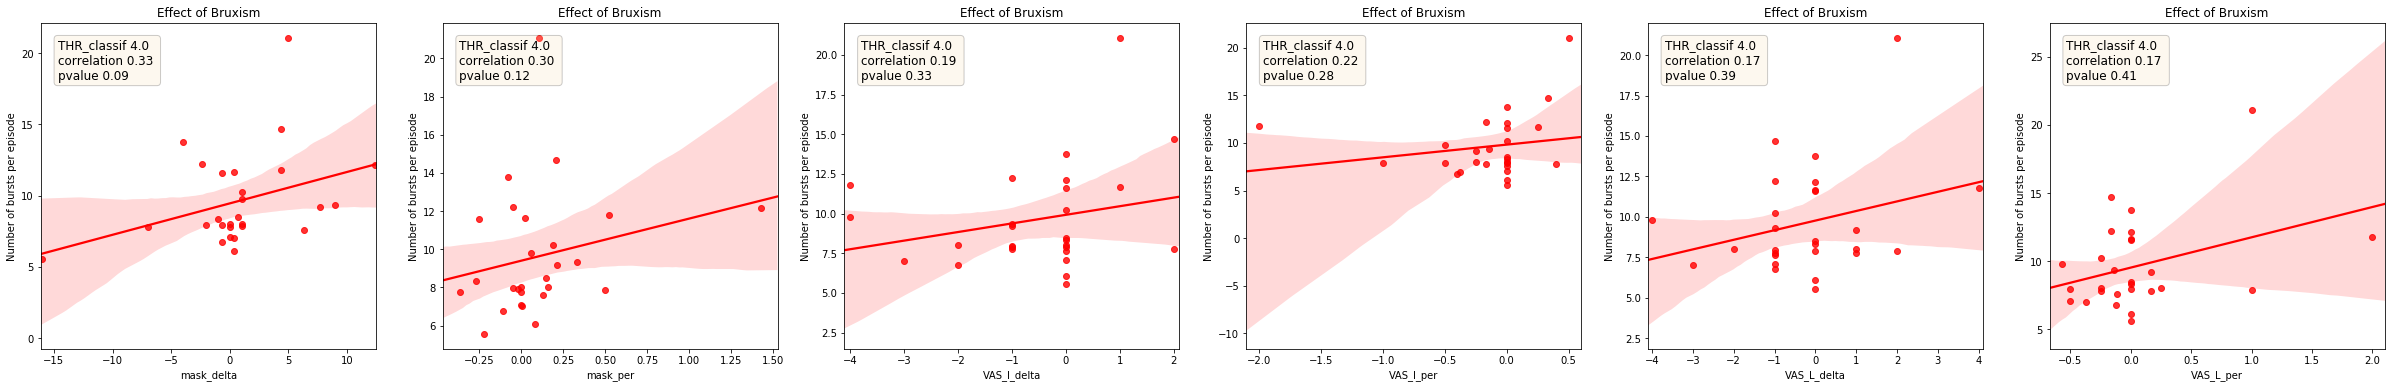

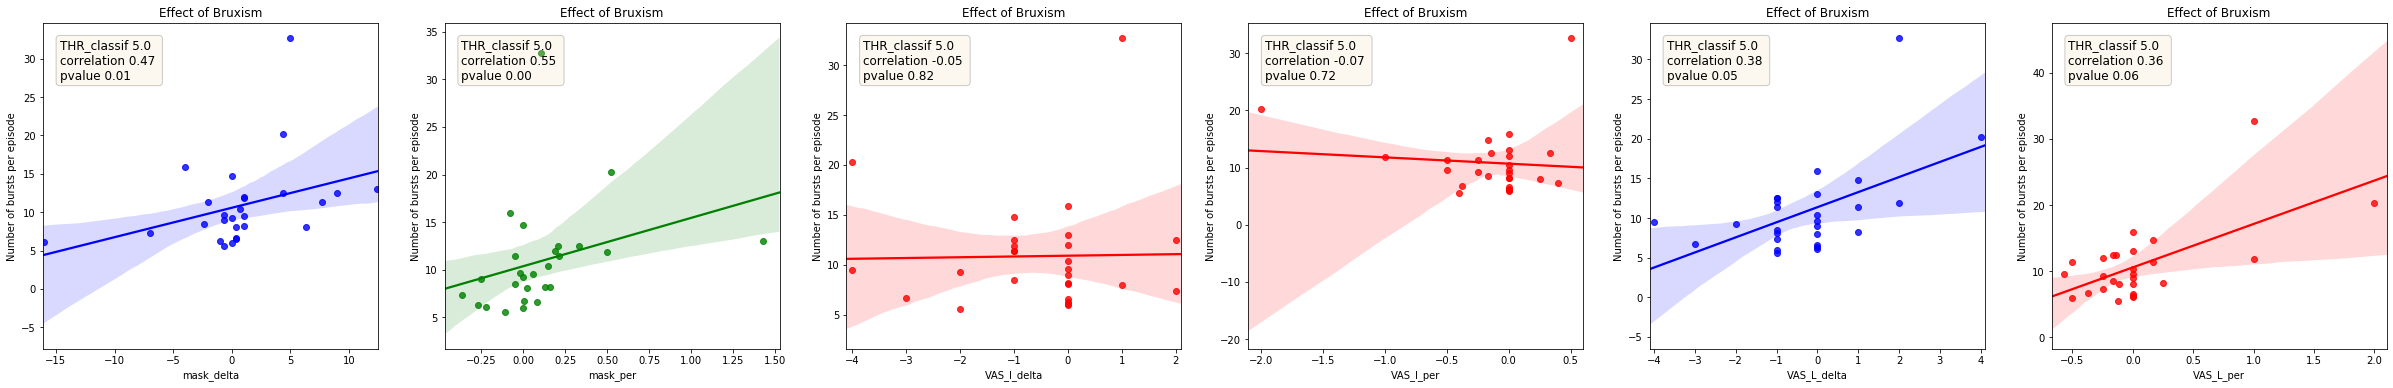

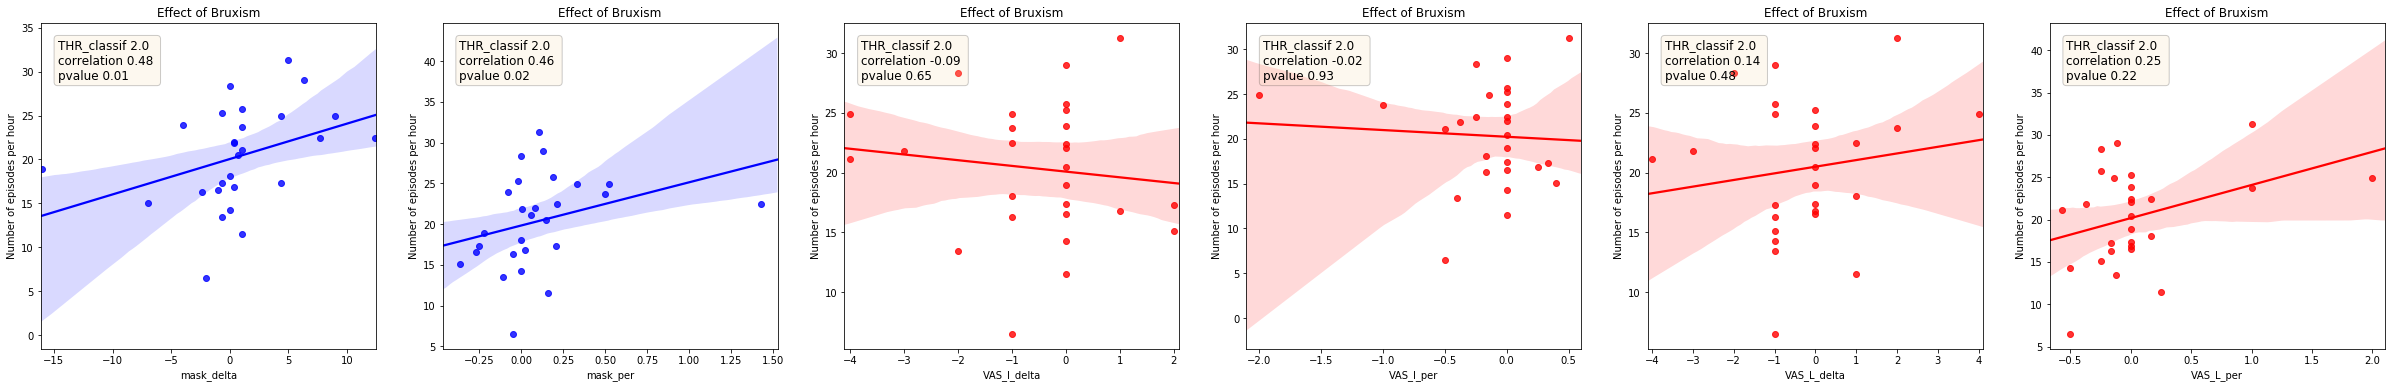

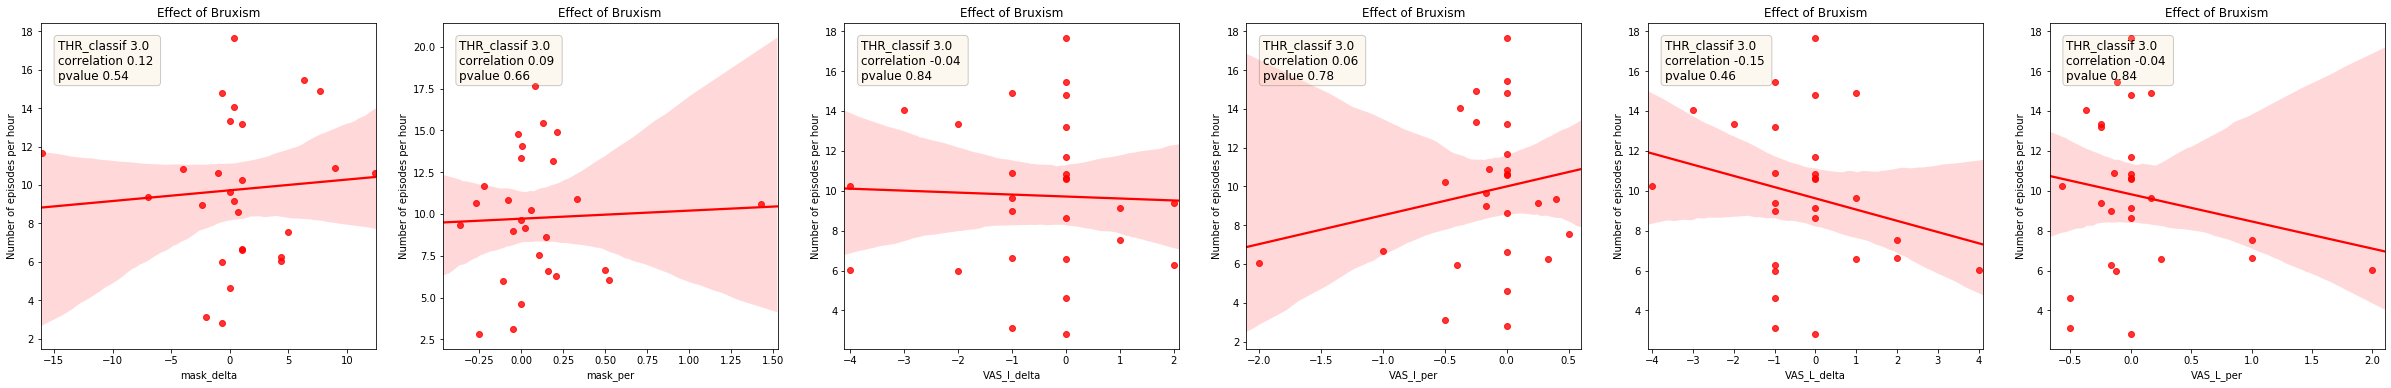

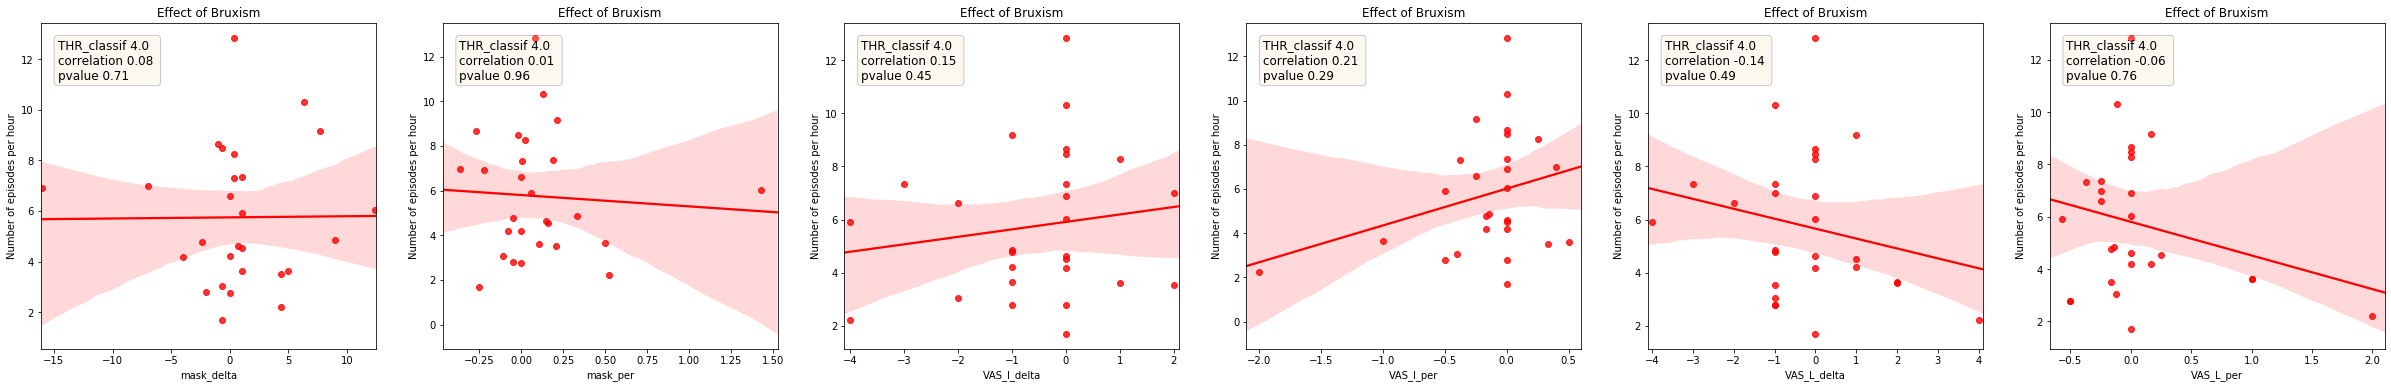

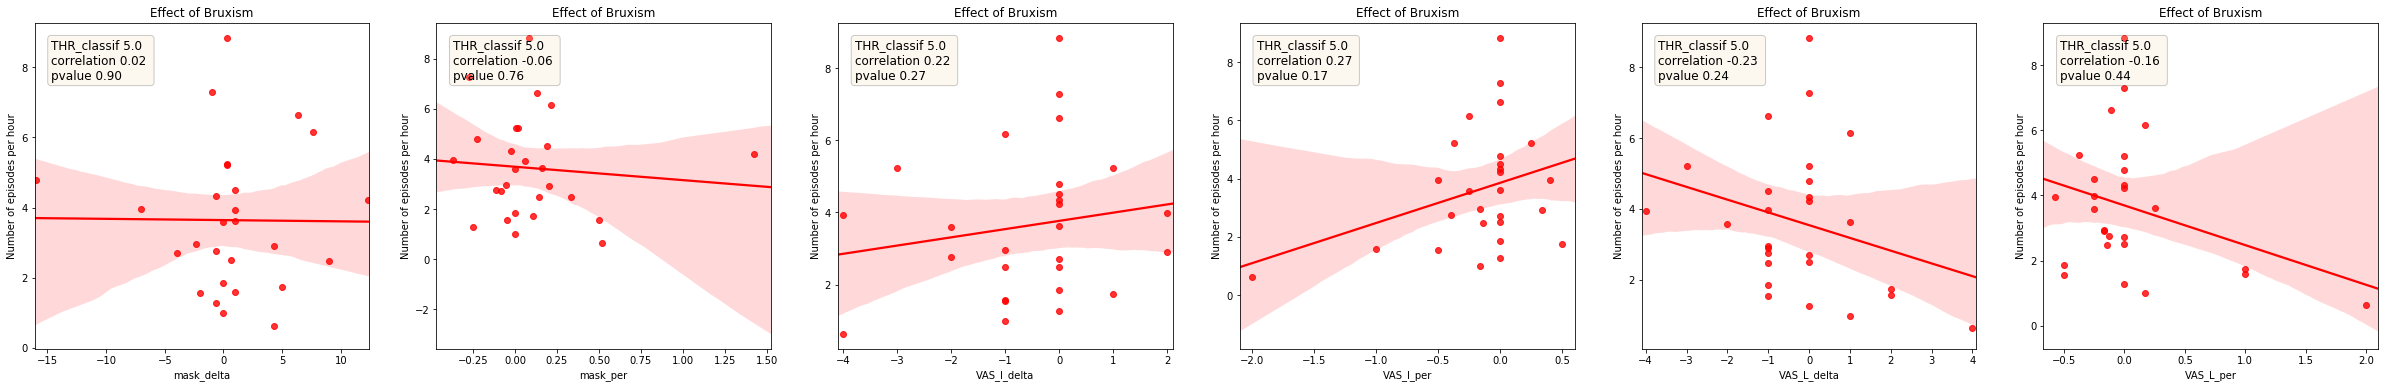

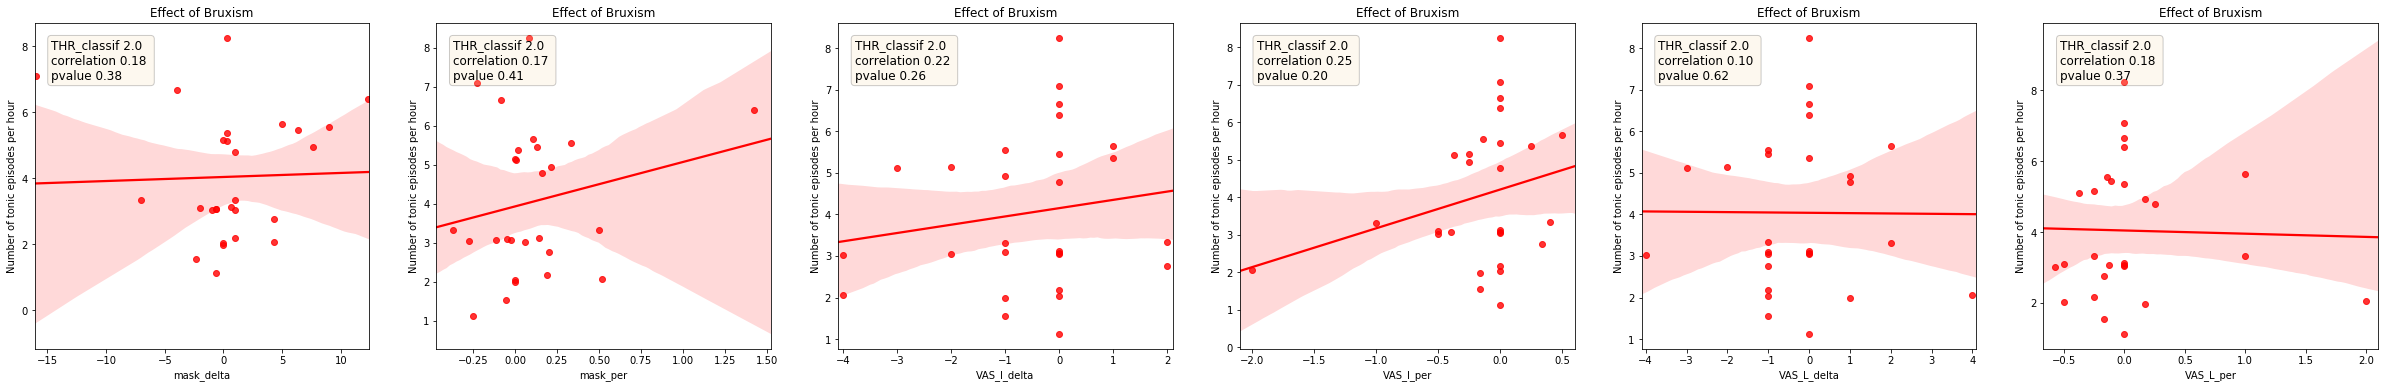

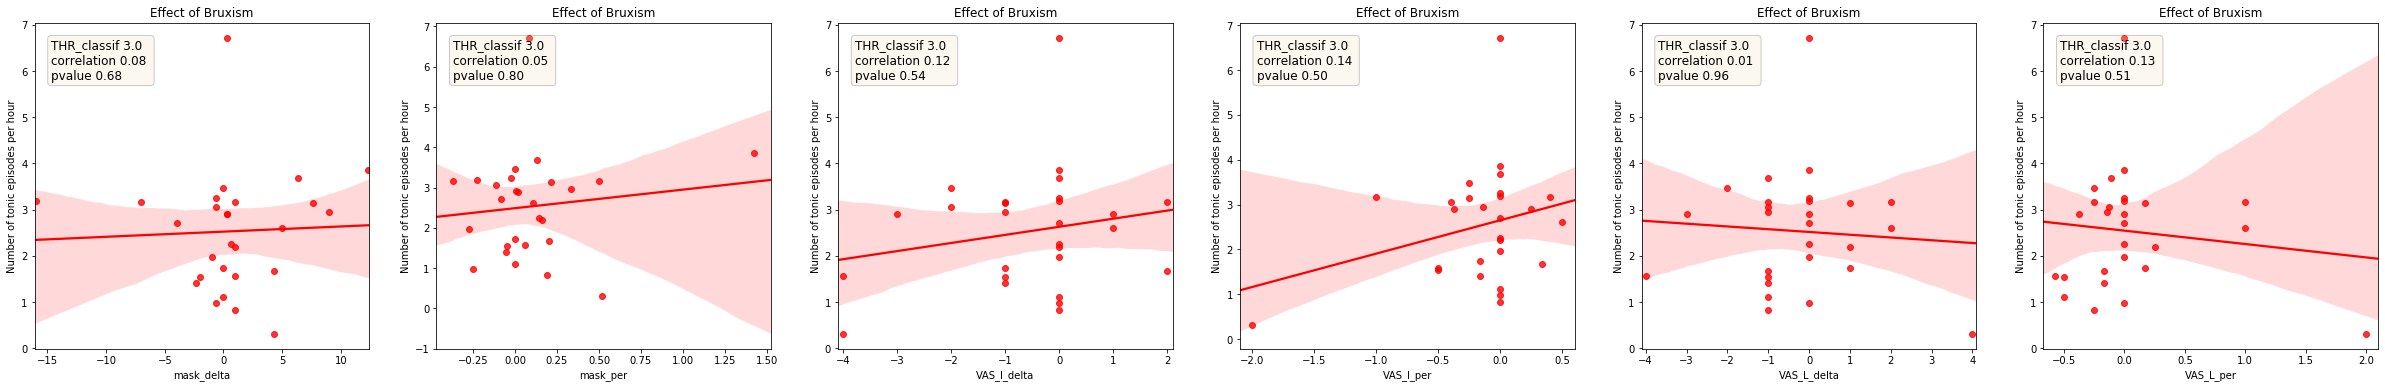

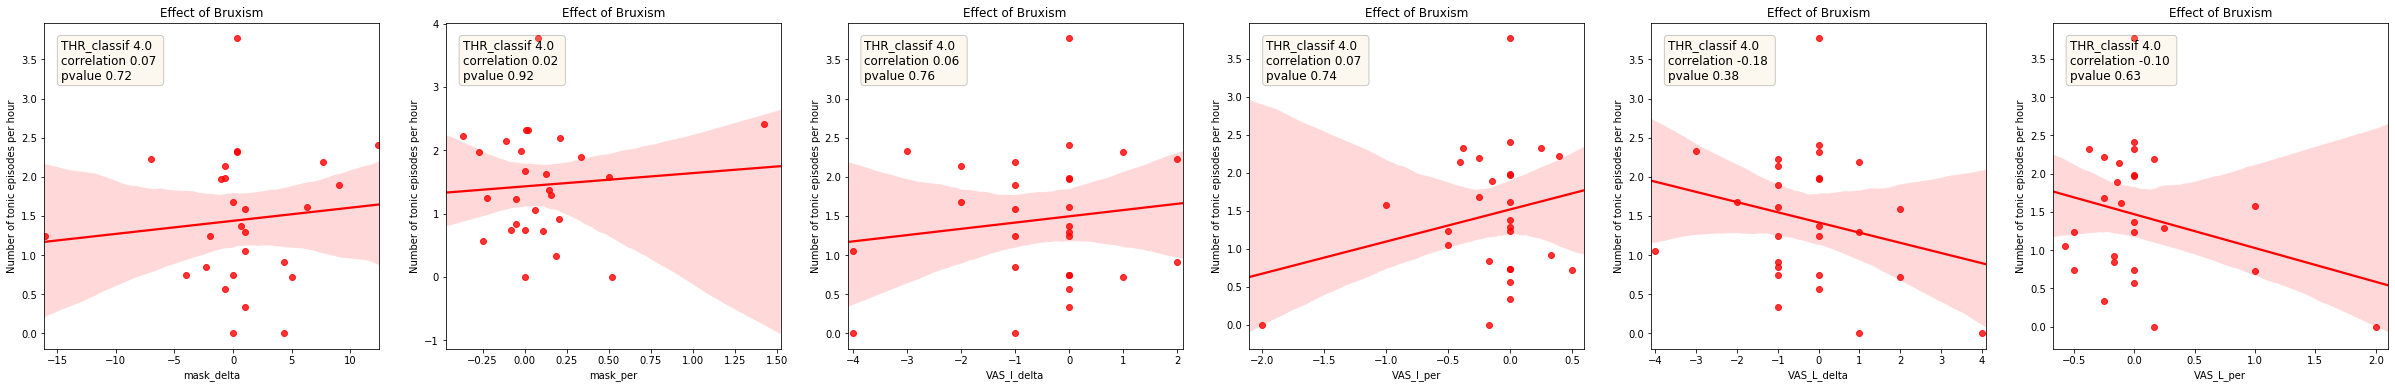

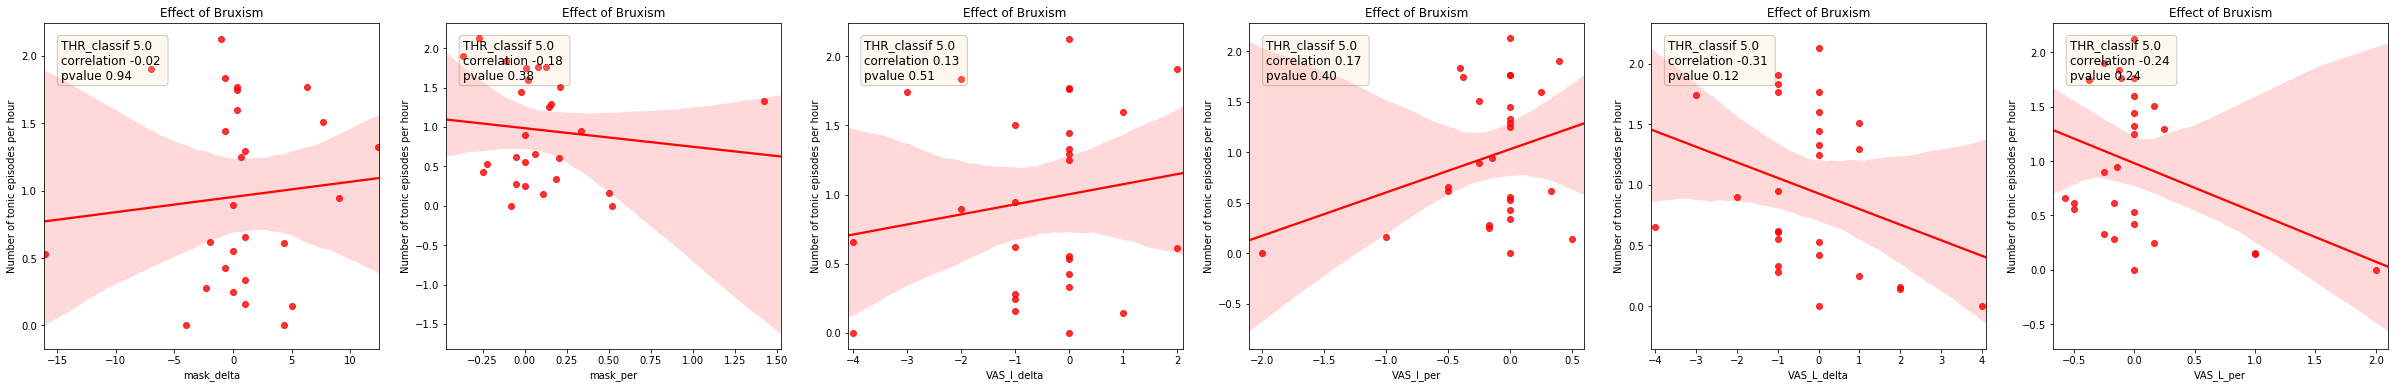

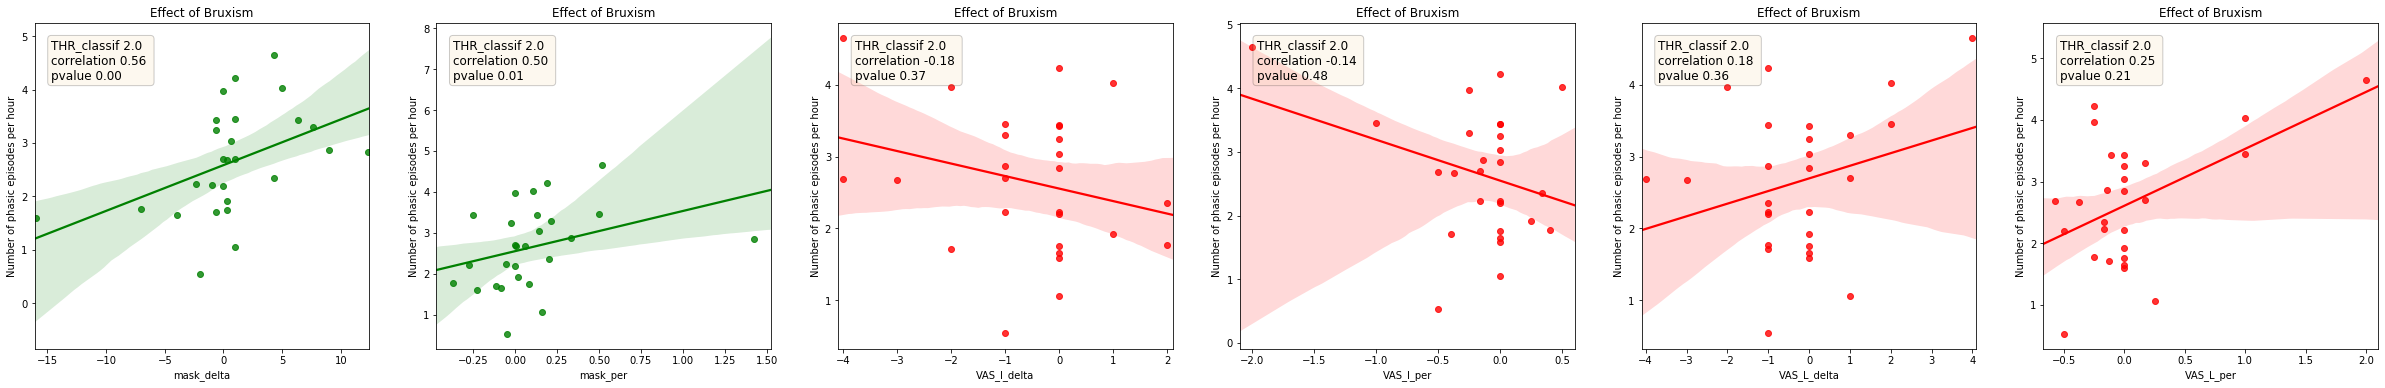

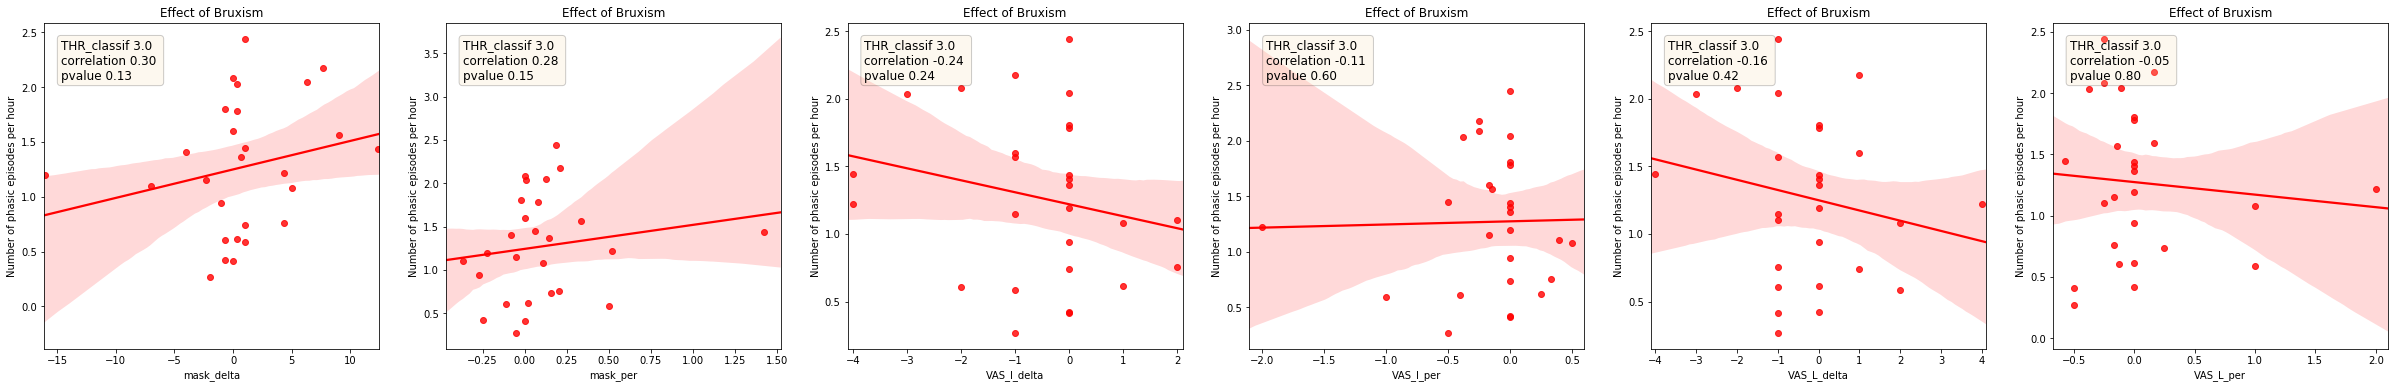

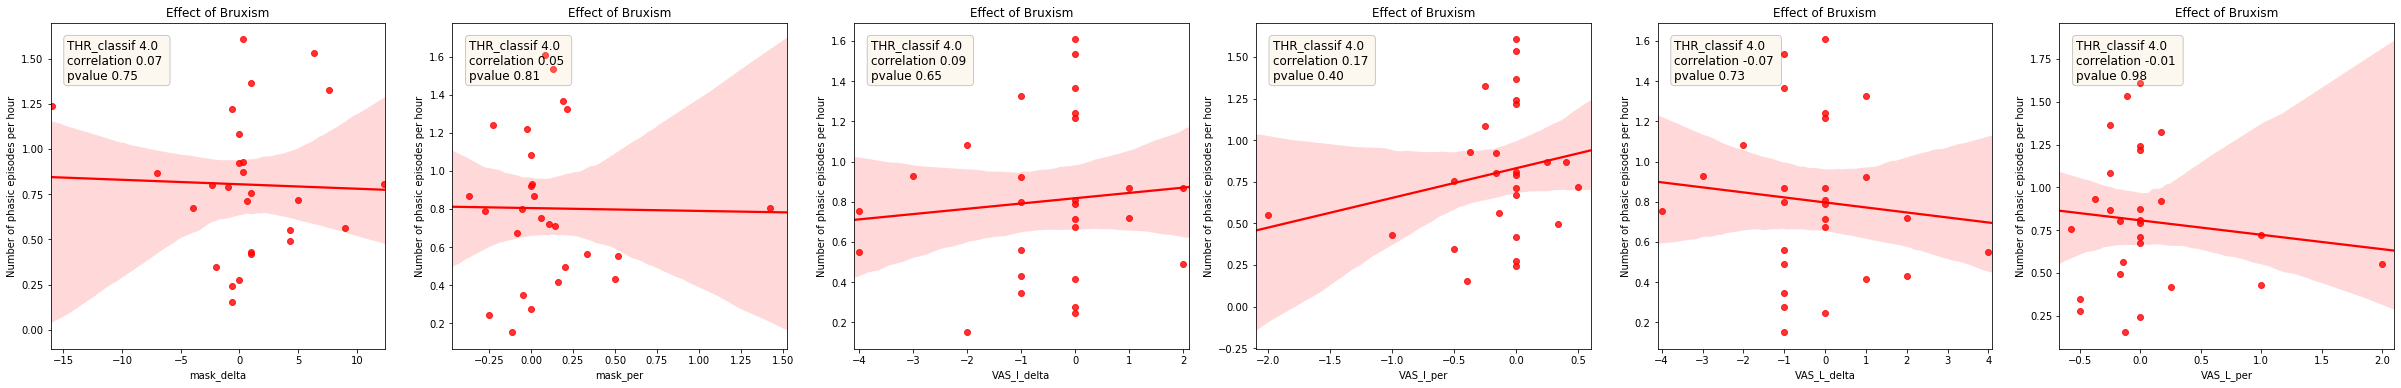

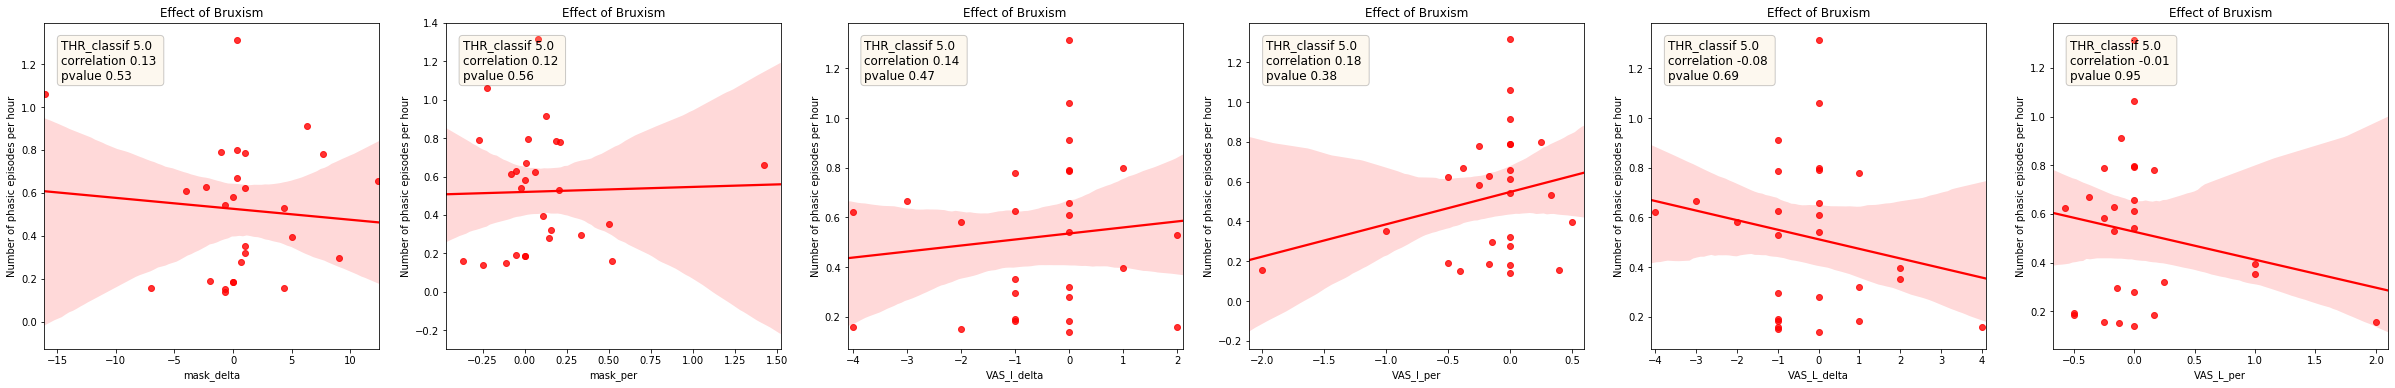

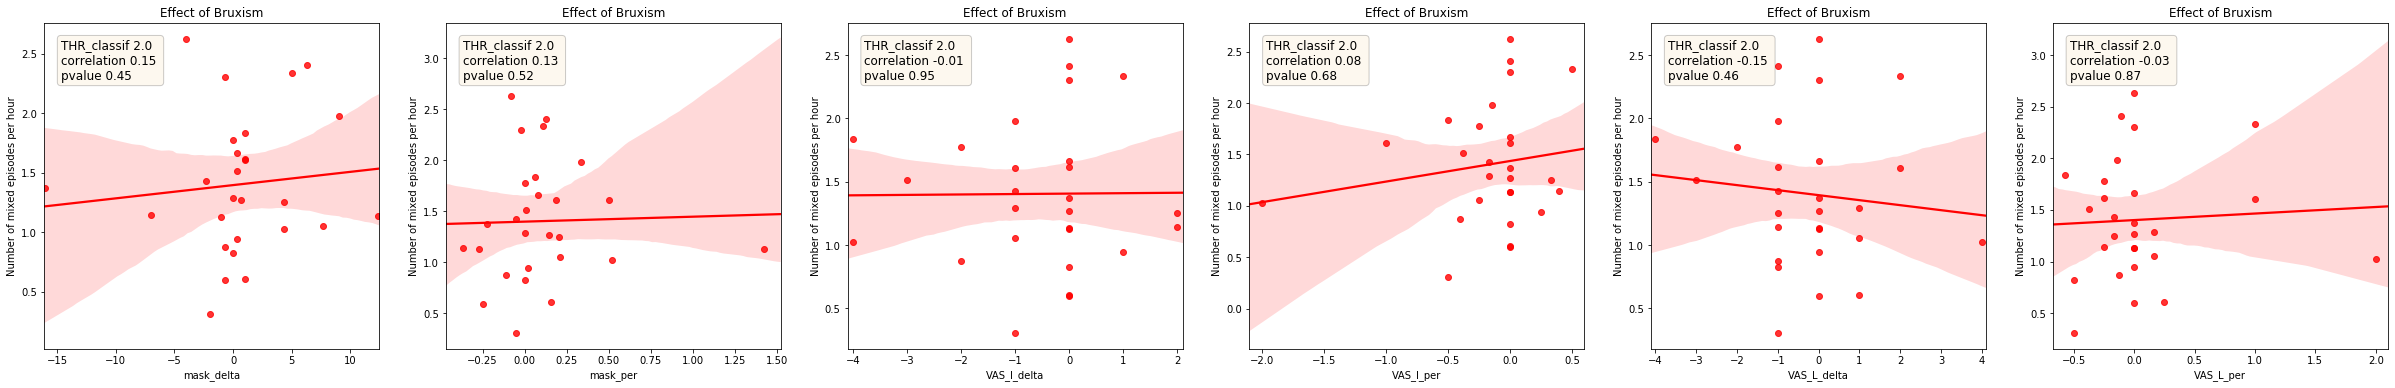

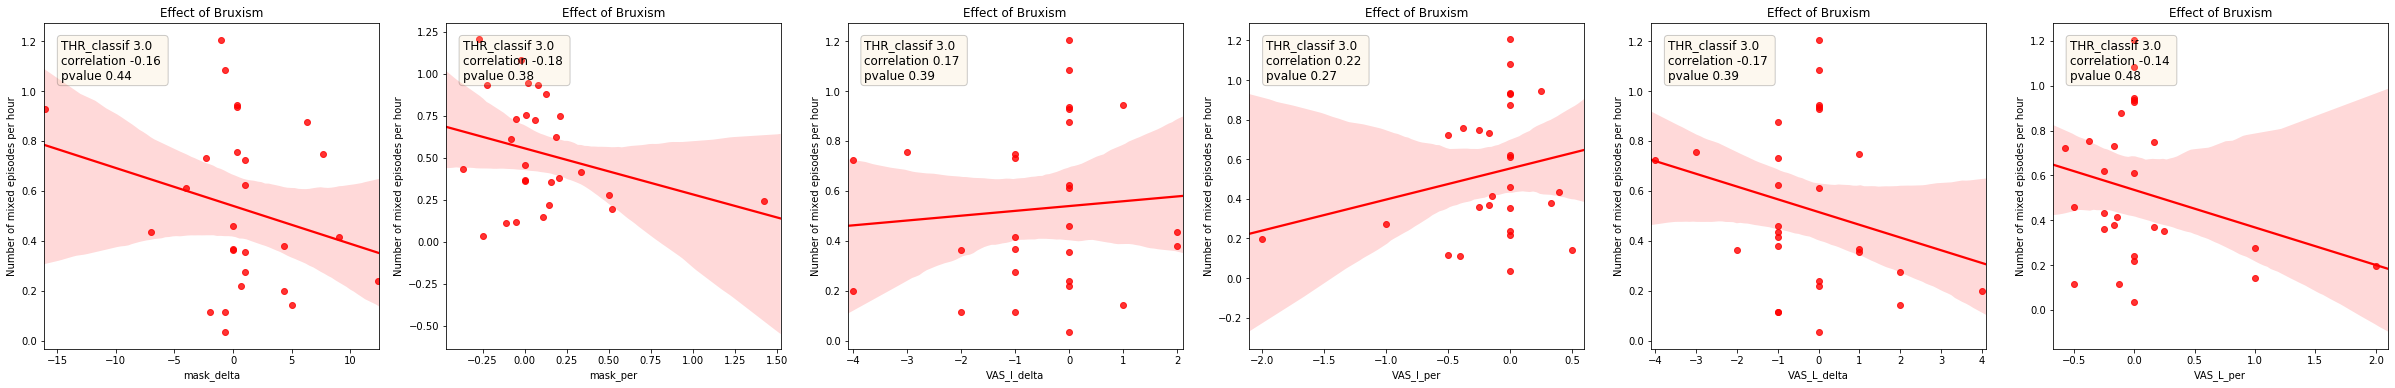

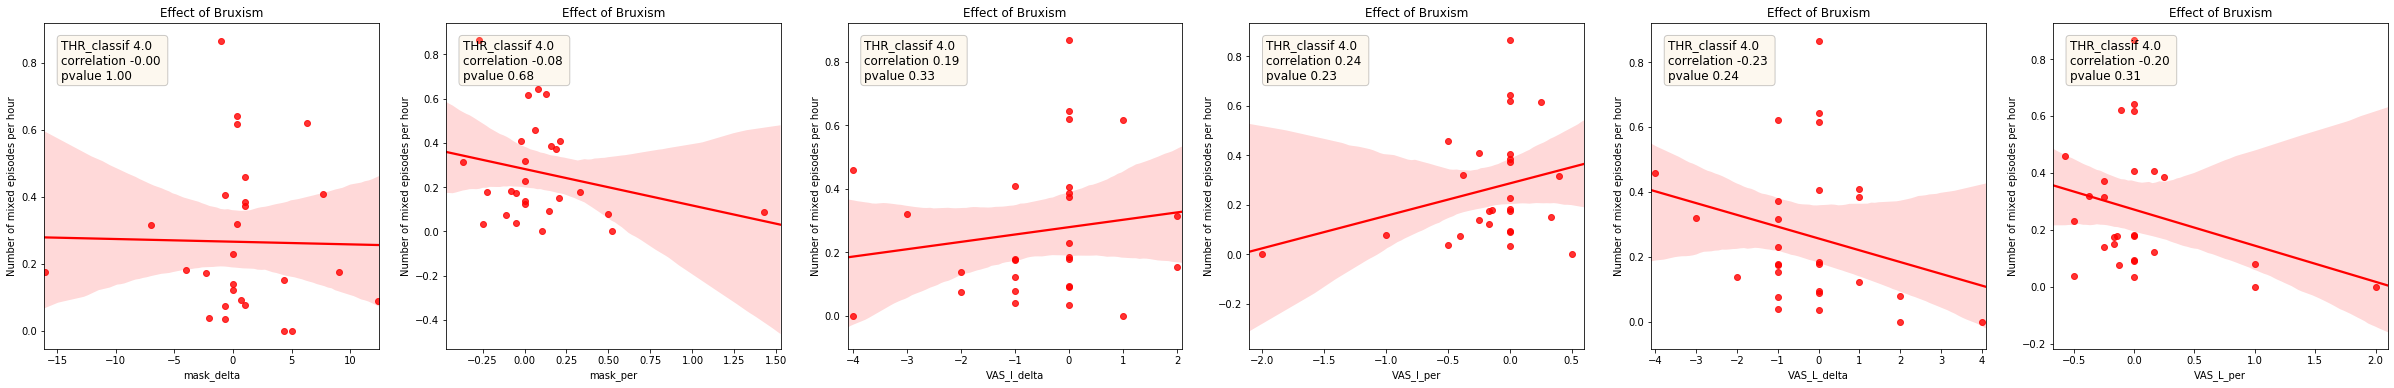

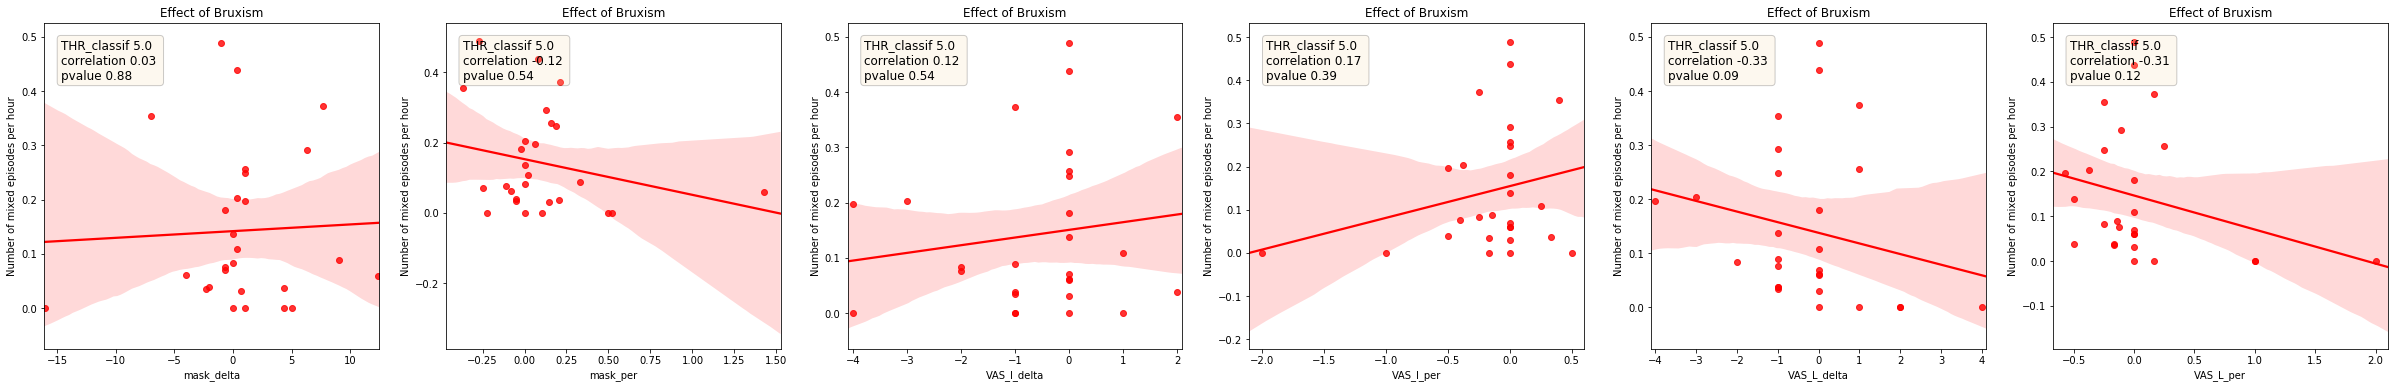

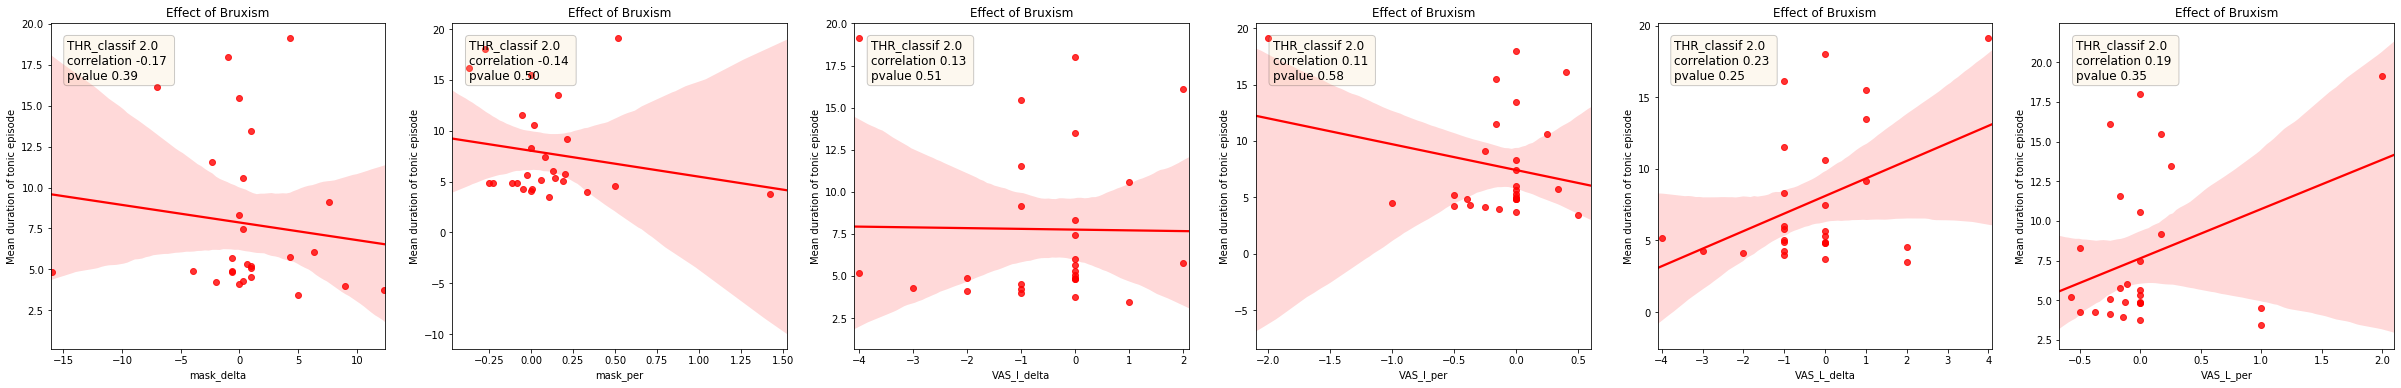

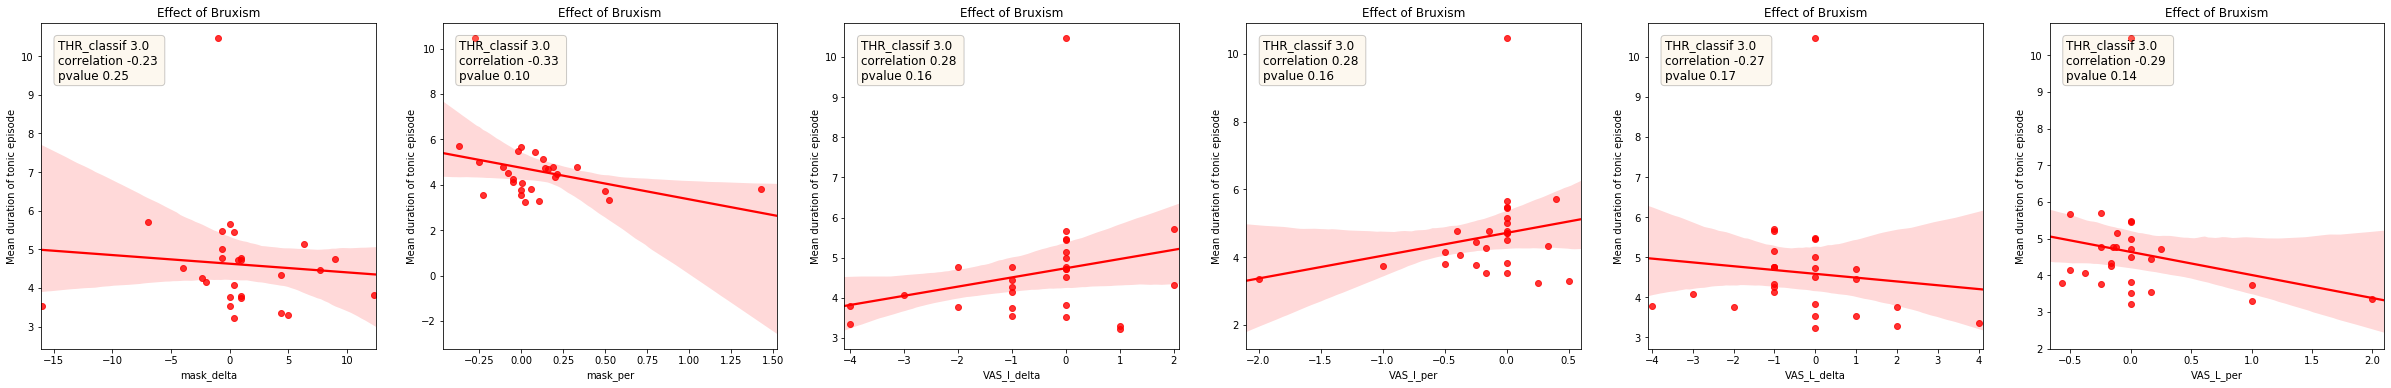

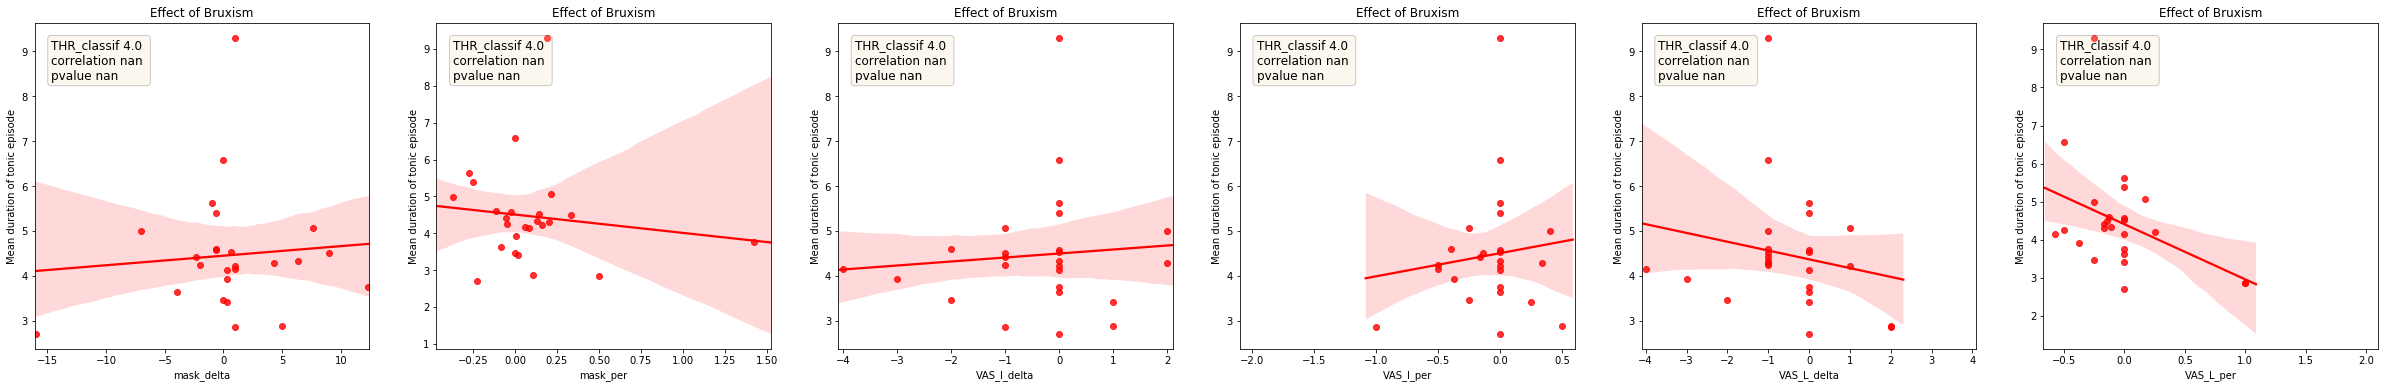

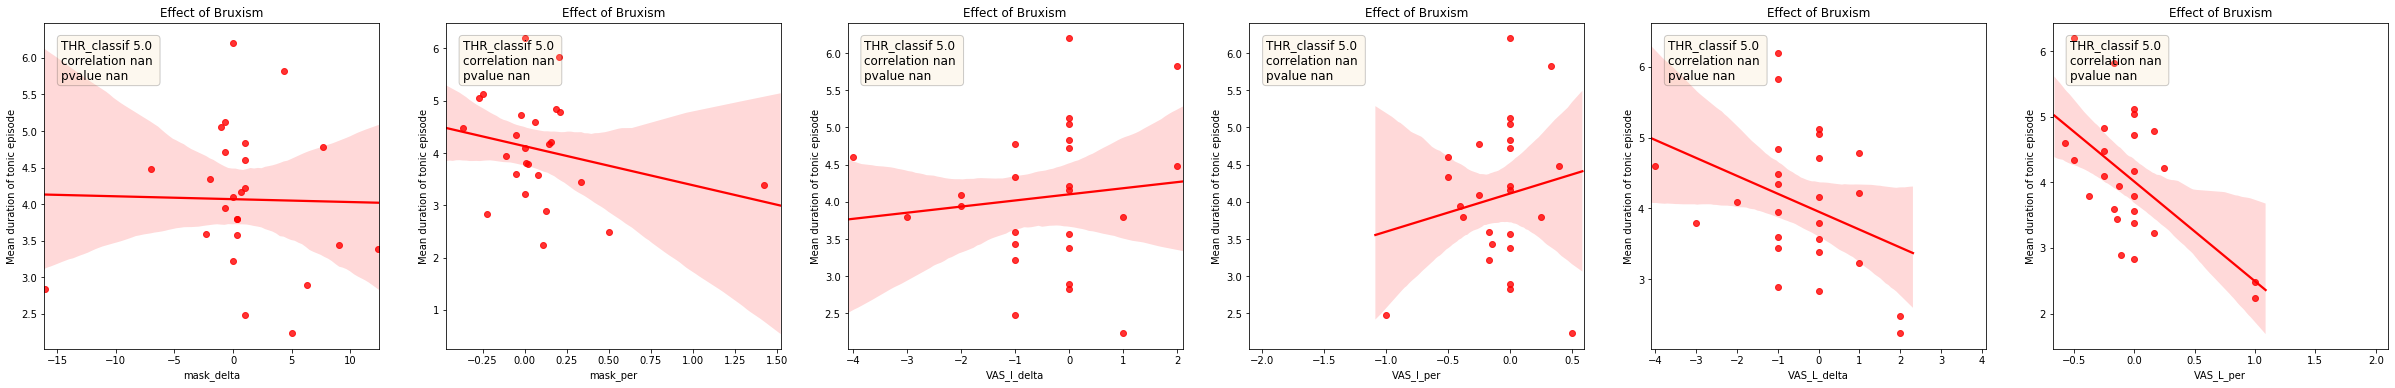

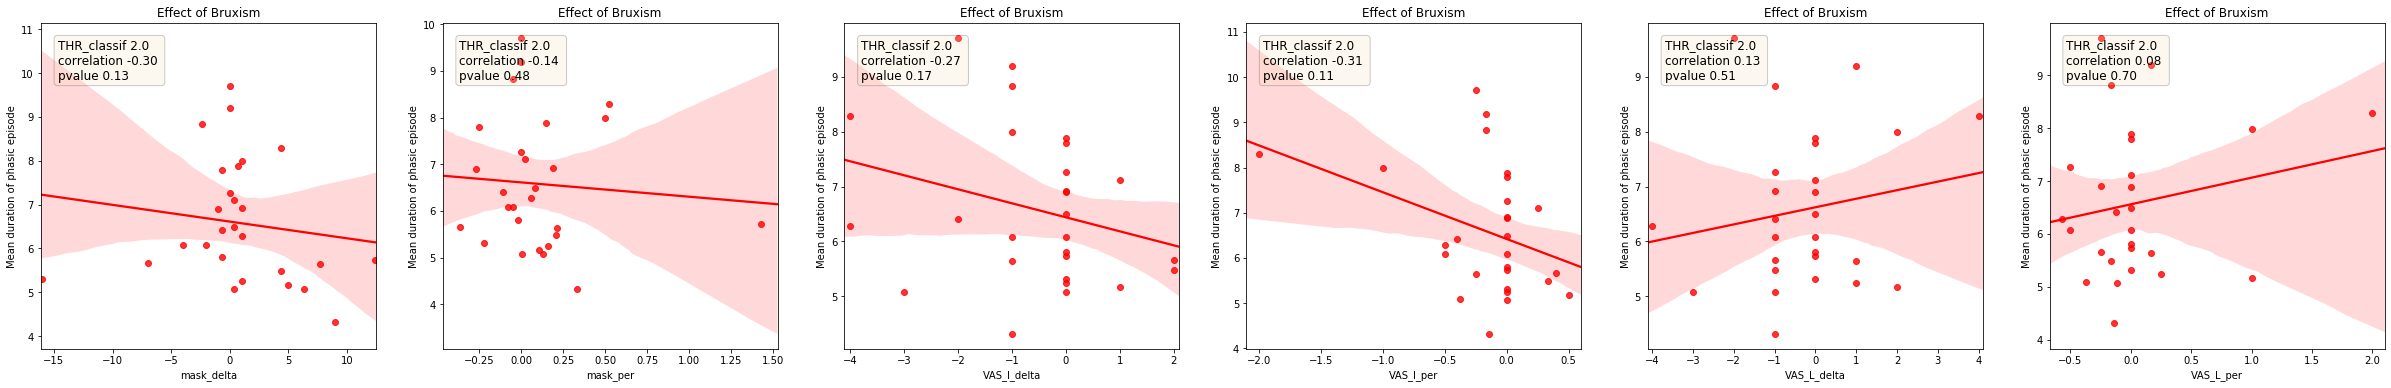

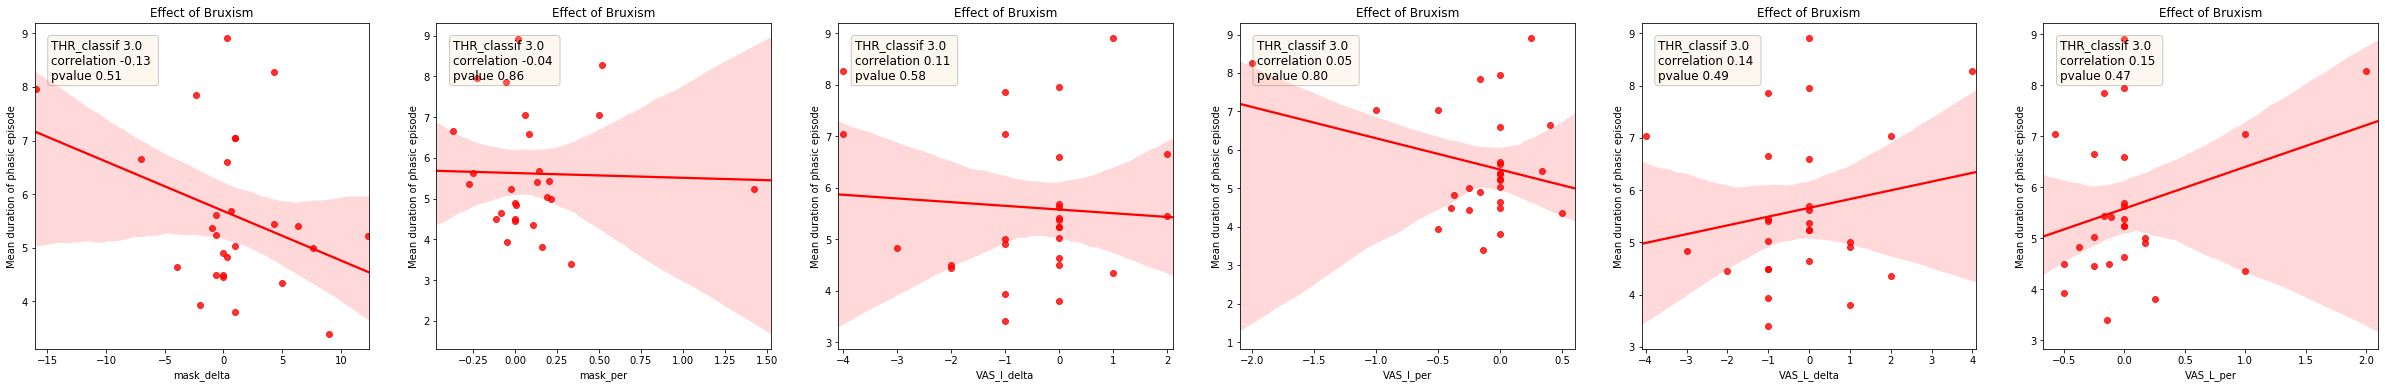

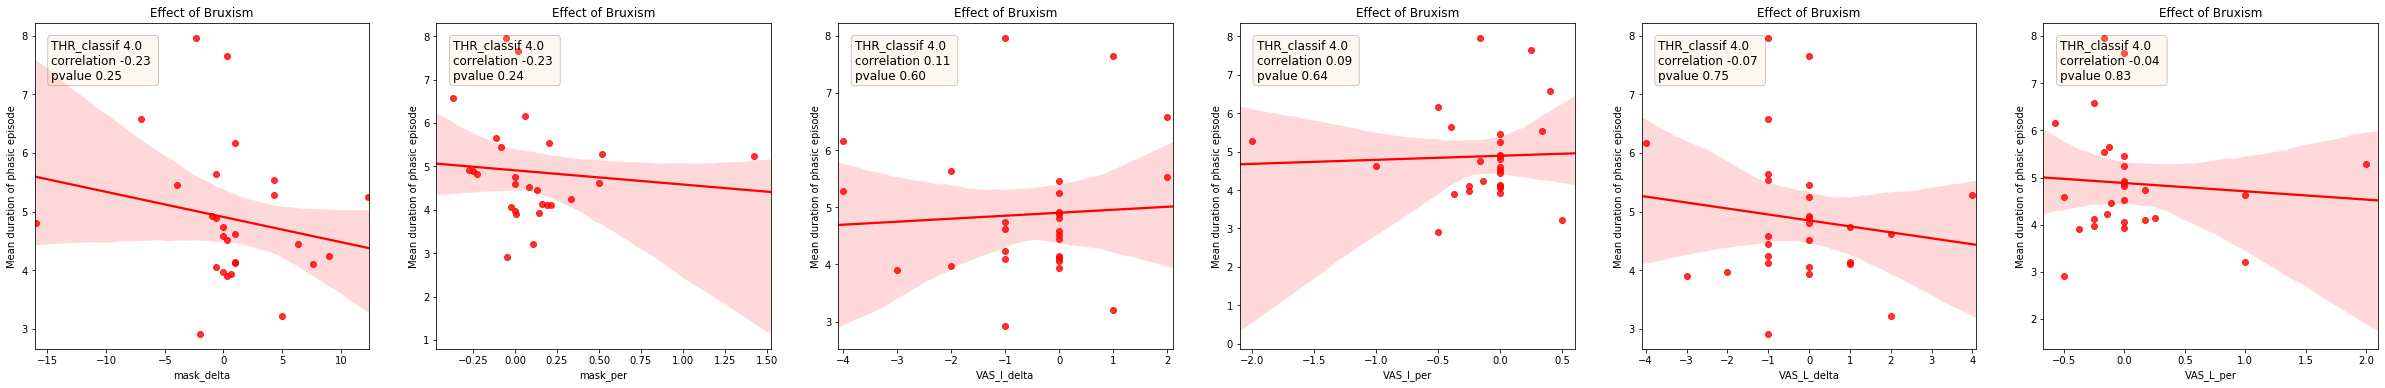

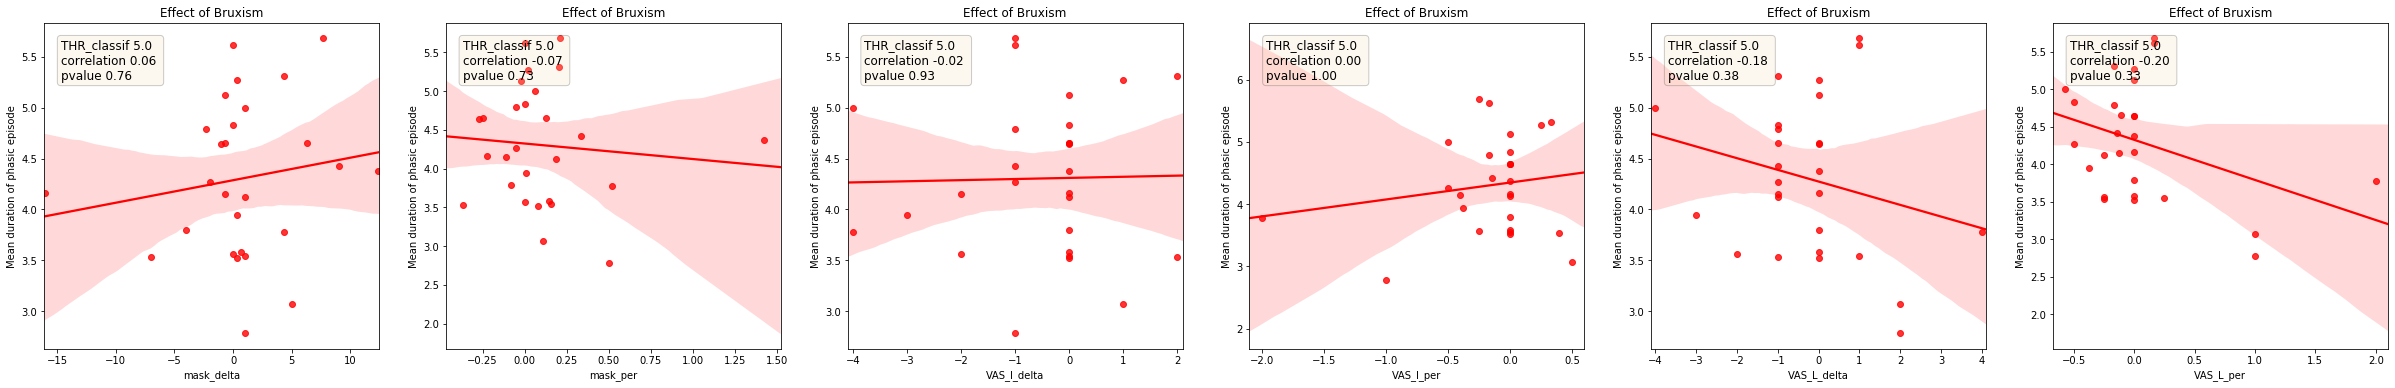

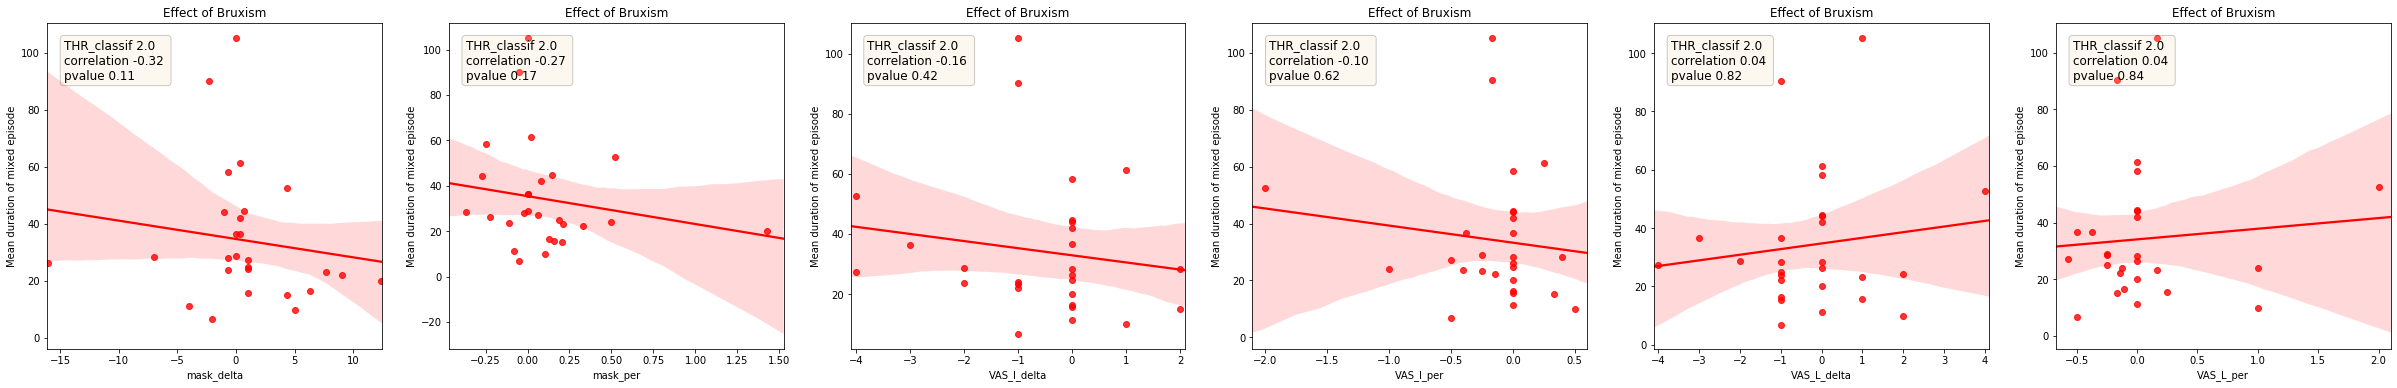

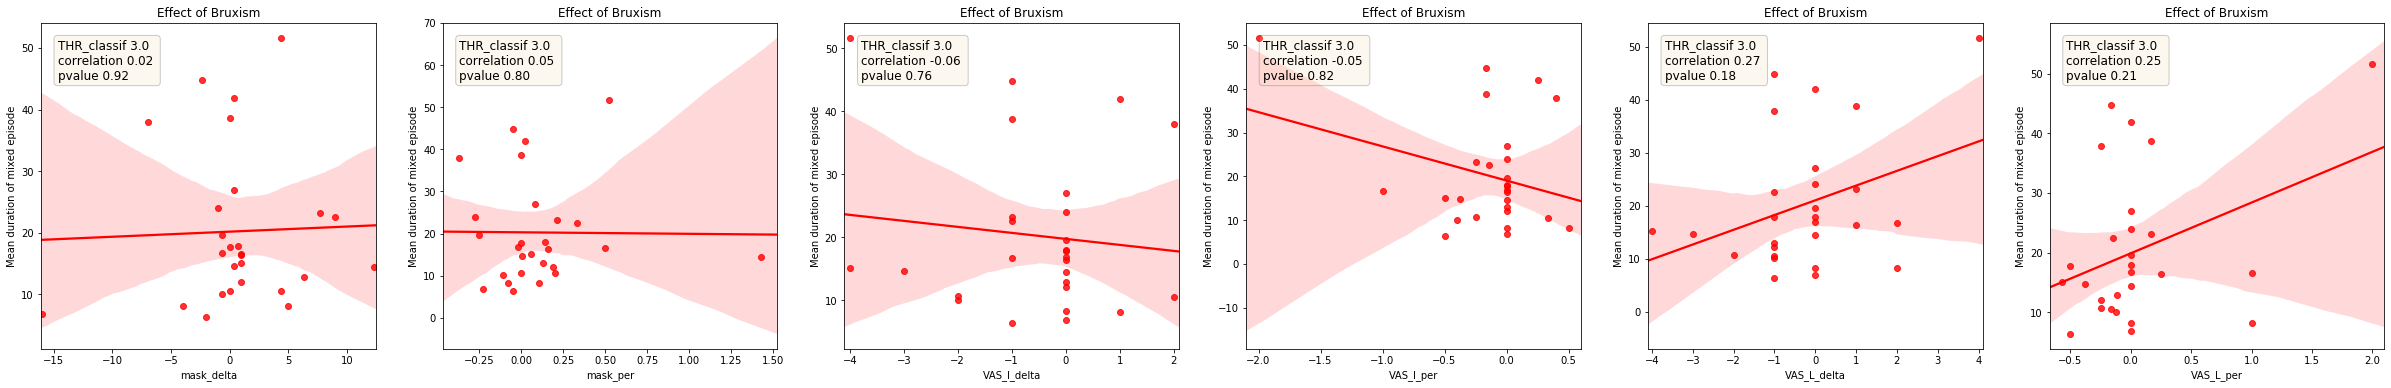

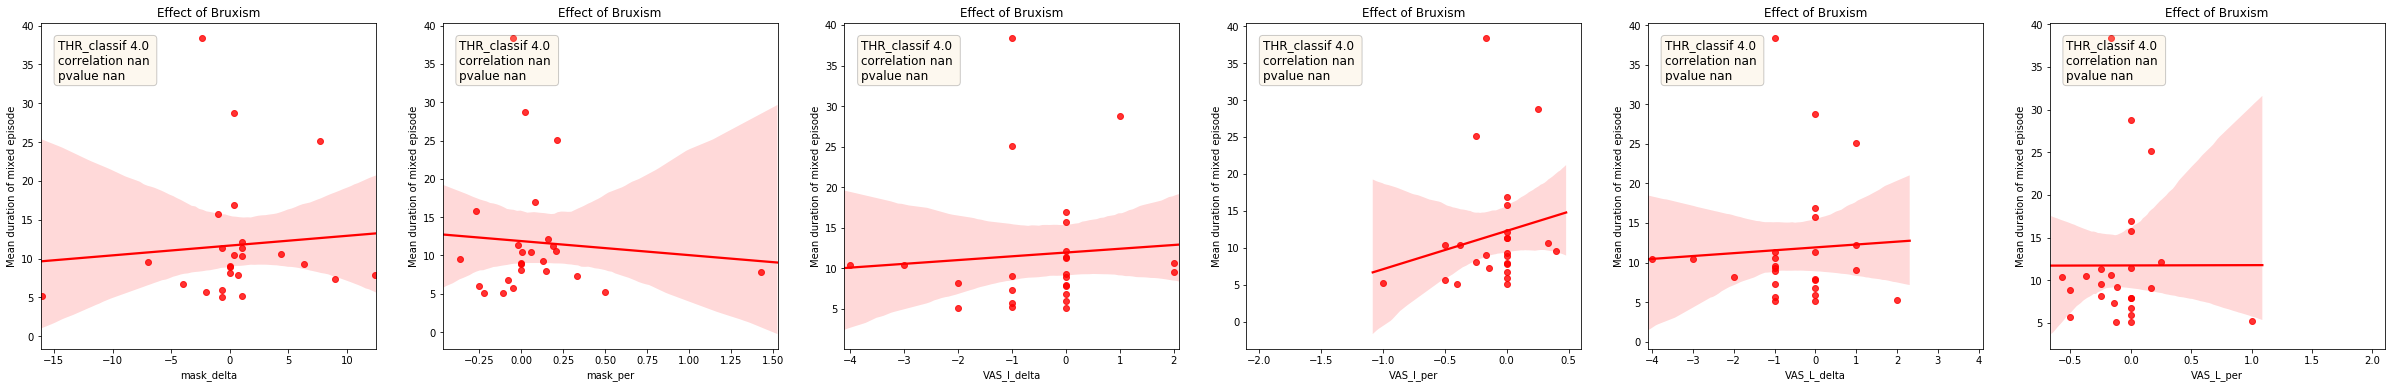

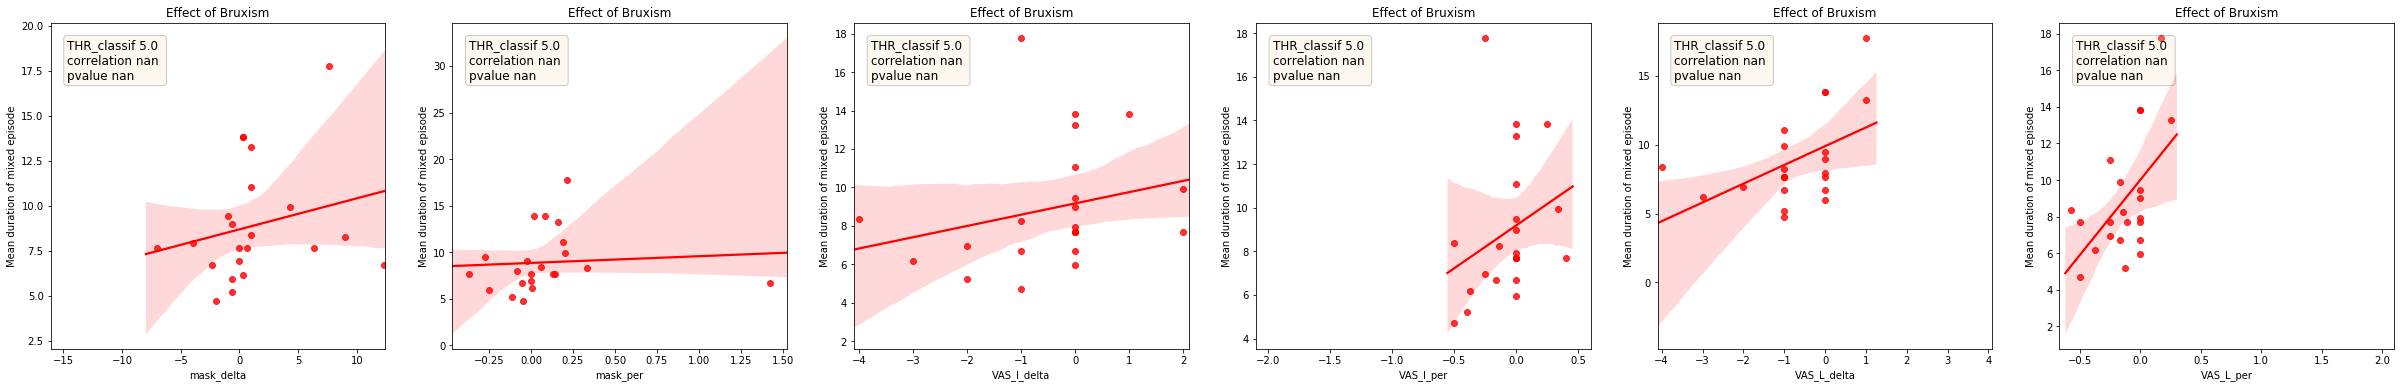

In [14]:
import seaborn as sns
from tinnsleep.visualization import regression_report_with_plot
plt.close("all")

data = reports.query("category != 'control'")
meta_results = regression_report_with_plot(data, effect_variable, quantitative_variables, conditions='THR_classif', title="Effect of Bruxism")

In [15]:
meta_results.query("pvalue < 0.05")

x_axis                              y_axis  THR_classif  correlation  \
0   mask_delta                 Clean data duration            2     0.400736   
0   mask_delta                 Clean data duration            3     0.400736   
0   mask_delta                 Clean data duration            4     0.400736   
0   mask_delta                 Clean data duration            5     0.400736   
0   mask_delta                Total burst duration            5     0.431963   
0   mask_delta               Total number of burst            4     0.410749   
0   mask_delta               Total number of burst            5     0.508881   
0    VAS_I_per           Number of bursts per hour            4     0.399915   
0   mask_delta           Number of bursts per hour            5     0.397981   
0   mask_delta            Total number of episodes            2     0.612772   
0     mask_per            Total number of episodes            2     0.517262   
0   mask_delta        Number of bursts per episode            5     0.471527   
0     mask_per        Number of bursts per episode            5     0.546510   
0  VAS_L_delta        Number of bursts per episode            5     0.383097   
0   mask_delta         Number of episodes per hour            2     0.484925   
0     mask_per         Number of episodes per hour            2     0.456934   
0   mask_delta  Number of phasic episodes per hour            2     0.556561   
0     mask_per  Number of phasic episodes per hour            2     0.500916   

     pvalue  
0  0.038314  
0  0.038314  
0  0.038314  
0  0.038314  
0  0.024447  
0  0.033315  
0  0.006714  
0  0.038749  
0  0.039790  
0  0.000679  
0  0.005727  
0  0.013032  
0  0.003184  
0  0.048561  
0  0.010358  
0  0.016572  
0  0.002570  
0  0.007781